In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from scipy.stats.stats import pearsonr

In [96]:
!ls drive/MyDrive/dm_dataset/
#!pip install pandas==1.3.4

country_codes.csv   male_players.csv	    players.pkl
female_players.csv  matches.pkl		    tennis_matches.csv
height_dataset.csv  matches_tounery_id.pkl


# Data&nbsp;loading

In [97]:
female = pd.read_csv('drive/MyDrive/dm_dataset/female_players.csv',  sep=r'\s*,\s*')
male = pd.read_csv('drive/MyDrive/dm_dataset/male_players.csv',  sep=r'\s*,\s*')
#matches = pd.read_csv('drive/MyDrive/dm_dataset/tennis_matches.csv',  sep=r'\s*,\s*')
matches = pd.read_pickle(("drive/MyDrive/dm_dataset/matches_tounery_id.pkl"))
# players = pd.read_pickle('players.pkl')
# players_stats = pd.read_pickle('player_matches.pkl')



/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


# Correlation


High correlation with dimension of the cour and spectetors num and revenue.  
Check also the very high negative correlation.  

In [98]:
corr_matrix = matches.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper = upper.applymap((lambda x: x if x>0.9 or x < -0.9 else 0), na_action='ignore')
upper=upper.replace(np.nan, 0)
upper = upper[(upper.T != 0).any()] #drop all row with all zero values
upper = upper.loc[:, (upper != 0).any(axis=0)] #drop columns with all 0
corr_matrix.style.background_gradient(cmap='coolwarm')


,best_of,draw_size,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_born_date,l_bpFaced,l_bpSaved,l_df,l_svpt,loser_age,loser_ht,loser_rank,loser_rank_points,match_num,minutes,tourney_date,tourney_revenue,tourney_spectators,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_ace,w_born_date,w_bpFaced,w_bpSaved,w_df,w_svpt,winner_age,winner_ht,winner_rank,winner_rank_points
best_of,1.000000,0.389872,0.320137,0.317651,0.263765,0.377058,0.168554,-0.078538,0.168689,0.138080,0.079444,0.349734,0.081535,0.139718,-0.102895,0.120226,-0.025610,0.318241,0.003687,0.333409,0.350720,0.304326,0.365631,0.285627,0.391209,0.172606,-0.088158,0.082244,0.084559,0.079747,0.319564,0.094937,0.156328,-0.130822,0.223401
draw_size,0.389872,1.000000,0.146259,0.128505,0.097181,0.079885,0.046469,-0.027397,0.097118,0.068609,0.034966,0.151269,0.087570,-0.074482,-0.231984,0.211360,0.137585,0.149129,0.178873,0.835847,0.932313,0.147035,0.152448,0.101645,0.088882,0.042256,-0.016958,0.075443,0.062828,0.046010,0.147526,0.079204,-0.058495,-0.239613,0.267265
l_1stIn,0.320137,0.146259,1.000000,0.935149,0.564409,0.809286,0.333071,-0.040924,0.443114,0.493876,0.150843,0.927748,0.057142,0.073223,-0.123721,0.093210,0.006146,0.829151,0.045497,0.126109,0.133596,0.767953,0.757490,0.570511,0.792083,0.228708,-0.025426,0.479149,0.361786,0.307614,0.799125,0.042803,0.082116,-0.075185,0.062365
l_1stWon,0.317651,0.128505,0.935149,1.000000,0.616649,0.837099,0.496449,-0.068993,0.259485,0.393127,0.181753,0.908543,0.081538,0.215581,-0.126076,0.096655,-0.001341,0.810322,0.033268,0.112652,0.115629,0.782581,0.828425,0.637947,0.826438,0.329144,-0.045692,0.391656,0.323533,0.284312,0.818131,0.059713,0.195181,-0.061047,0.049060
l_2ndWon,0.263765,0.097181,0.564409,0.616649,1.000000,0.718705,0.414033,-0.047550,0.217435,0.335681,0.243454,0.780498,0.046625,0.181489,-0.073645,0.039510,-0.003258,0.712660,-0.005145,0.085991,0.088472,0.641251,0.682780,0.596211,0.709524,0.287674,-0.045440,0.337360,0.282718,0.285393,0.704890,0.046470,0.185023,-0.019440,0.009470
l_SvGms,0.377058,0.079885,0.809286,0.837099,0.718705,1.000000,0.426401,-0.049613,0.274007,0.293390,0.231390,0.869532,0.058372,0.169581,-0.106572,0.081573,-0.000152,0.837108,0.026308,0.034369,0.061540,0.802377,0.806233,0.648197,0.981288,0.278299,-0.038834,0.490274,0.375549,0.345778,0.858016,0.049543,0.149626,-0.047414,0.040413
l_ace,0.168554,0.046469,0.333071,0.496449,0.414033,0.426401,1.000000,-0.067606,-0.074496,0.073707,0.136237,0.405872,0.063867,0.417292,-0.069697,0.060044,-0.012617,0.323724,-0.012313,0.040960,0.036981,0.361758,0.453355,0.369248,0.425108,0.298483,-0.079947,0.056381,0.079208,0.099758,0.385861,0.079464,0.218333,-0.021906,0.017957
l_born_date,-0.078538,-0.027397,-0.040924,-0.068993,-0.047550,-0.049613,-0.067606,1.000000,0.036055,0.003407,0.047127,-0.041264,-0.937759,-0.070171,0.185766,-0.119581,0.003438,-0.040123,0.252010,-0.012004,-0.015967,-0.040174,-0.063511,-0.053521,-0.054556,-0.094859,0.147623,0.017647,0.005562,0.011409,-0.044098,-0.062444,-0.093736,0.103531,-0.082268
l_bpFaced,0.168689,0.097118,0.443114,0.259485,0.217435,0.274007,-0.074496,0.036055,1.000000,0.911294,0.267536,0.483469,-0.030653,-0.185433,-0.029438,0.026436,0.004995,0.382550,0.019457,0.079756,0.092742,0.254077,0.139779,0.113286,0.251130,-0.119483,0.020478,0.383912,0.234634,0.205561,0.273728,-0.014203,-0.192221,-0.046057,0.046853
l_bpSaved,0.138080,0.068609,0.493876,0.393127,0.335681,0.293390,0.073707,0.003407,0.911294,1.000000,0.216842,0.534269,0.002253,-0.056754,-0.032247,0.023771,0.002380,0.394420,0.018093,0.057433,0.065539,0.271114,0.229419,0.188473,0.281024,0.008133,0.000432,0.259311,0.179447,0.154474,0.289323,0.006204,-0.057040,-0.034132,0.033681


Non ci sono correlazioni negative.
Abbiamo scelto come threshold 90 per essere sicuri di averte feature altamente correlate.  
Le coppie interessandi trovate corrispondono sia per i winner che per i loser:
- 1stIn & svpt
- 1stIn & 1stWon
- bpSaved & bpFaced


# Feature Engineering

## Matches

### Sets & Games

We extract set and game information by the score feature

In [99]:
matches['n_sets'] = matches['score'].str.count('[1-9]?[0-9]-[1-9]?[0-9]')
def num_set_won(arr):
    count = 0
    for ele in arr:
      numbers = ele.split('-')
      if int(numbers[0]) > int(numbers[1]):
          count+=1
    return count

def sets_counts(row):
  w_sets_won = 0
  w_games_won = 0
  l_games_won = 0
  set_scores = str(row['scoreapp']).split(" ")
  if not((len(set_scores) == 1)):
    for sett in set_scores:
      #check if RET/DEF/[num]
      game_score = sett.split('-')
      if (len(game_score) > 1) and (len(game_score[0]) > 0) and (len(game_score[1]) >0): 
        """and not(sett.__contains__("[")):"""
        w_sets_won = w_sets_won + int( int(game_score[0]) > int(game_score[1]) )
        w_games_won = w_games_won + int(game_score[0])
        l_games_won = l_games_won + int(game_score[1])
  row['w_sets_won'],row['w_games_won'],row['l_games_won']= [w_sets_won,w_games_won,l_games_won]
  return row
  

matches['scoreapp'] = matches['score'].str.replace("\\([1-9]?[0-9]\\)|\\[|\\]","")
matches = matches.apply(lambda row: sets_counts(row), axis=1)
matches['l_sets_won'] = matches.n_sets - matches.w_sets_won
matches[['scoreapp', 'score']].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: The default value of regex will change from True to False in a future version.


,scoreapp,score
0,6-4 3-6 6-2,6-4 3-6 6-2
1,7-6 6-2,7-6(6) 6-2
2,6-2 6-2,6-2 6-2
3,6-4 7-6,6-4 7-6(2)
4,6-7 6-3 6-4,6-7(2) 6-3 6-4


#### Stats & Plots

In [100]:
print(matches['w_sets_won'].describe())
print(matches['l_sets_won'].describe())
print(matches['w_games_won'].describe())
print(matches['l_games_won'].describe())

count    81982.000000
mean         2.022334
std          0.244631
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: w_sets_won, dtype: float64
count    81982.000000
mean         0.357591
std          0.498432
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: l_sets_won, dtype: float64
count    81982.000000
mean        13.821619
std          2.881563
min          0.000000
25%         12.000000
50%         13.000000
75%         15.000000
max         51.000000
Name: w_games_won, dtype: float64
count    81982.000000
mean         8.788856
std          4.359906
min          0.000000
25%          6.000000
50%          8.000000
75%         12.000000
max         48.000000
Name: l_games_won, dtype: float64


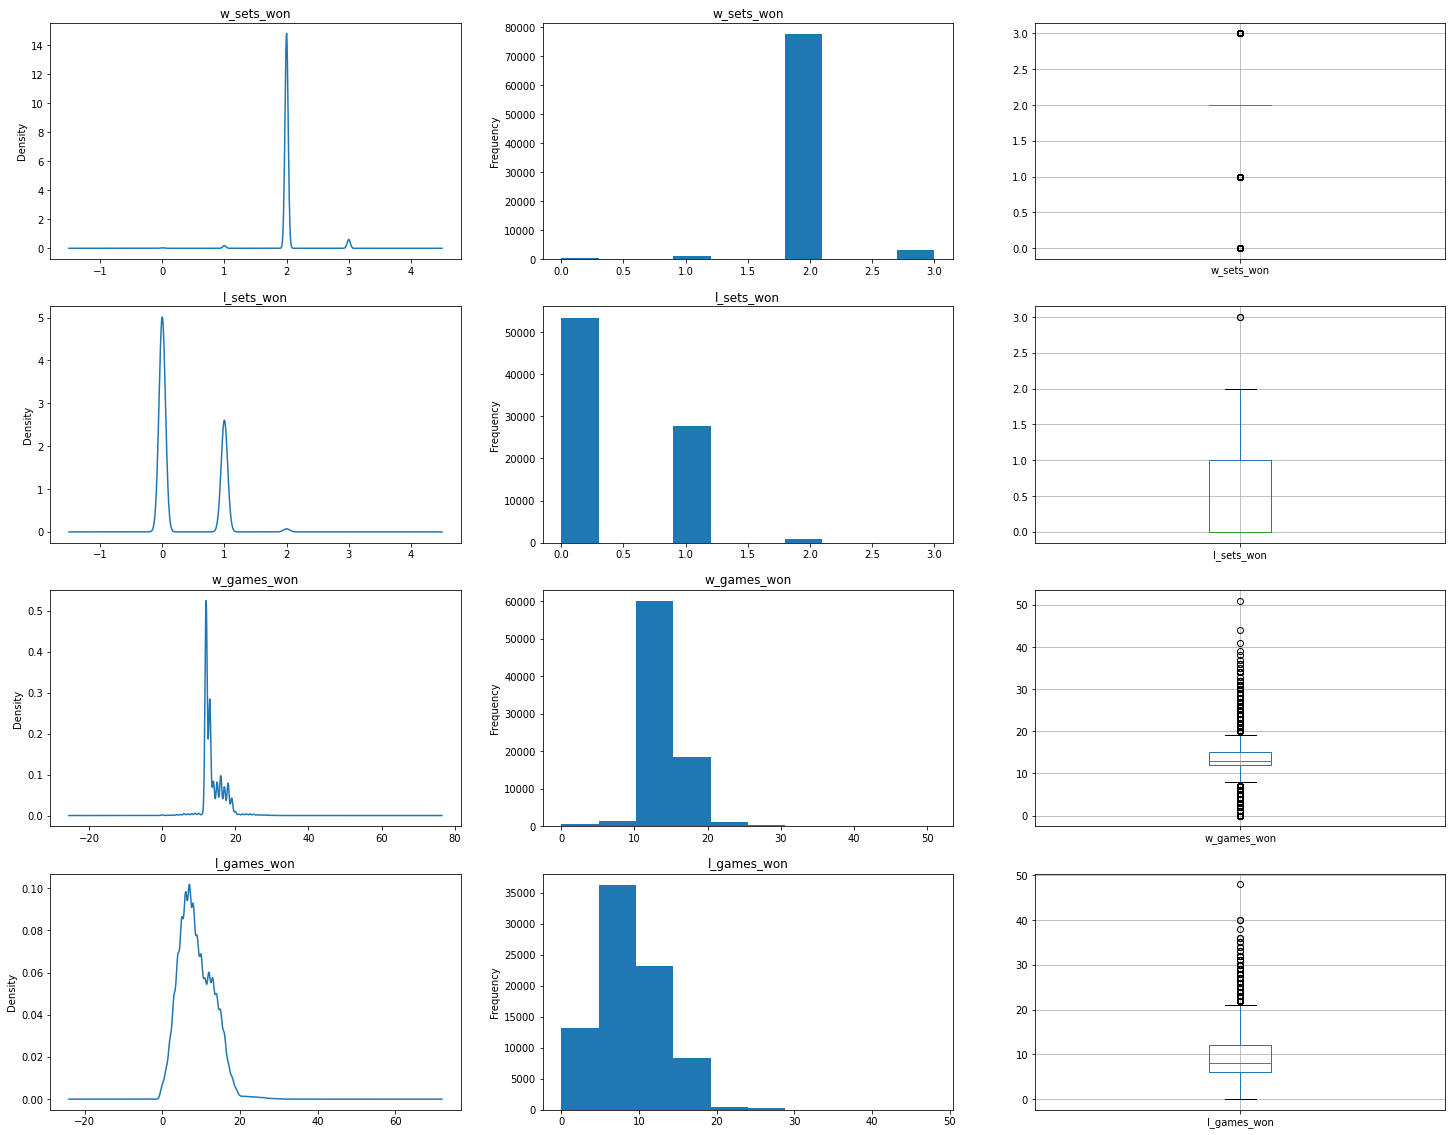

In [101]:
fig, axes = plt.subplots(4,3,figsize=(25,20))
matches['w_sets_won'].plot(kind='kde', title='w_sets_won', ax=axes[0][0])
matches['w_sets_won'].plot(kind='hist', title='w_sets_won', ax=axes[0][1])
matches.boxplot(column=['w_sets_won'], ax=axes[0][2])

matches['l_sets_won'].plot(kind='kde', title='l_sets_won', ax=axes[1][0])
matches['l_sets_won'].plot(kind='hist', title='l_sets_won', ax=axes[1][1])
matches.boxplot(column=['l_sets_won'], ax=axes[1][2])

matches['w_games_won'].plot(kind='kde', title='w_games_won', ax=axes[2][0])
matches['w_games_won'].plot(kind='hist', title='w_games_won', ax=axes[2][1])
matches.boxplot(column=['w_games_won'], ax=axes[2][2])


matches['l_games_won'].plot(kind='kde', title='l_games_won', ax=axes[3][0])
matches['l_games_won'].plot(kind='hist', title='l_games_won', ax=axes[3][1])
matches.boxplot(column=['l_games_won'], ax=axes[3][2])
plt.show()


### Tiebreaks

tiebreaks_total: A tie-break set is played with the same rules as the advantage set, except that when the score is tied at 6–6, a tie-break game (or tiebreaker) is played. Typically, the tie-break game continues until one side has won seven points with a margin of two or more points. 
We extract tiebreak won by the winner useing the score

In [102]:
matches['tiebreaks_total'] = matches['score'].str.count("\\(")

def tie_count(row):
  w_tb_won = 0
  if len(row['tieapp']) > 0:
    for sett in row['tieapp']:
      s = re.search("([0-9]?[0-9]-[0-9]?[0-9])(\\([0-9]\\))", sett)
      tb = list(s.groups())[1]
      s=list(s.groups())[0].split("-")
      w_tb_won = w_tb_won+ int(int(s[0]) > int(s[1]))
  row['w_tb_won'] = w_tb_won
  return row


#print(matches['score'].apply(lambda row: re.findall("[0-9]?[0-9]-[0-9]?[0-9]\\([0-9]\\)", str(row))))
matches['tieapp'] = matches['score'].apply(lambda row: re.findall("[0-9]-[0-9]\\([0-9]\\)", str(row)))
matches = matches.apply(lambda row: tie_count(row), axis=1)
matches['l_tb_won'] = matches.tiebreaks_total - matches.w_tb_won


#### Stats & Plots

In [103]:
print(matches['w_tb_won'].describe())
print(matches['l_tb_won'].describe())
print(matches['tiebreaks_total'].describe())

count    81982.000000
mean         0.261679
std          0.488099
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: w_tb_won, dtype: float64
count    81982.000000
mean         0.070735
std          0.259316
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: l_tb_won, dtype: float64
count    81982.000000
mean         0.332414
std          0.560781
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          4.000000
Name: tiebreaks_total, dtype: float64


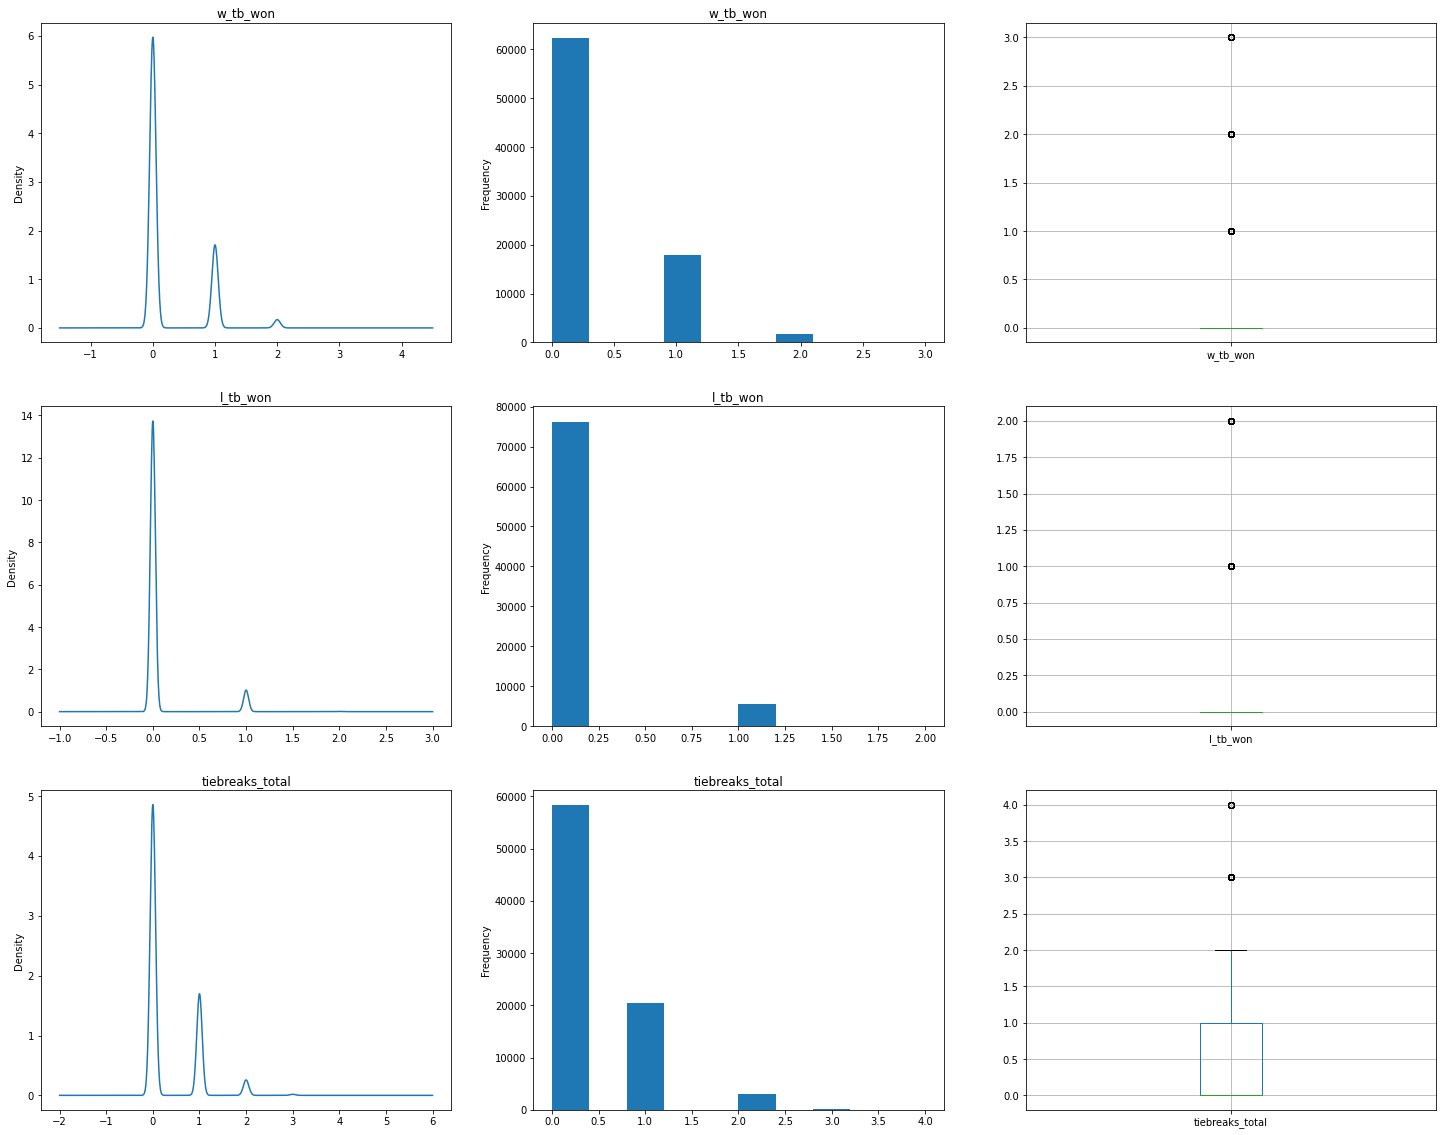

In [104]:
fig, axes = plt.subplots(3,3,figsize=(25,20))
matches['w_tb_won'].plot(kind='kde', title='w_tb_won', ax=axes[0][0])
matches['w_tb_won'].plot(kind='hist', title='w_tb_won', ax=axes[0][1])
matches.boxplot(column=['w_tb_won'], ax=axes[0][2])

matches['l_tb_won'].plot(kind='kde', title='l_tb_won', ax=axes[1][0])
matches['l_tb_won'].plot(kind='hist', title='l_tb_won', ax=axes[1][1])
matches.boxplot(column=['l_tb_won'], ax=axes[1][2])

matches['tiebreaks_total'].plot(kind='kde', title='tiebreaks_total', ax=axes[2][0])
matches['tiebreaks_total'].plot(kind='hist', title='tiebreaks_total', ax=axes[2][1])
matches.boxplot(column=['tiebreaks_total'], ax=axes[2][2])

plt.show()


### 2ndIn

In [105]:
matches['w_2ndIn'] = matches.w_svpt - matches.w_1stIn - matches.w_df
matches['l_2ndIn'] = matches.l_svpt - matches.l_1stIn - matches.l_df

#### Stats & Plots

In [106]:
print(matches['w_2ndIn'].describe())
print(matches['l_2ndIn'].describe())

count    81982.000000
mean        24.154534
std          9.906332
min        -20.000000
25%         17.000000
50%         23.000000
75%         30.000000
max         92.000000
Name: w_2ndIn, dtype: float64
count    81982.000000
mean        25.381584
std          9.879785
min         -3.000000
25%         18.000000
50%         24.000000
75%         31.000000
max        102.000000
Name: l_2ndIn, dtype: float64


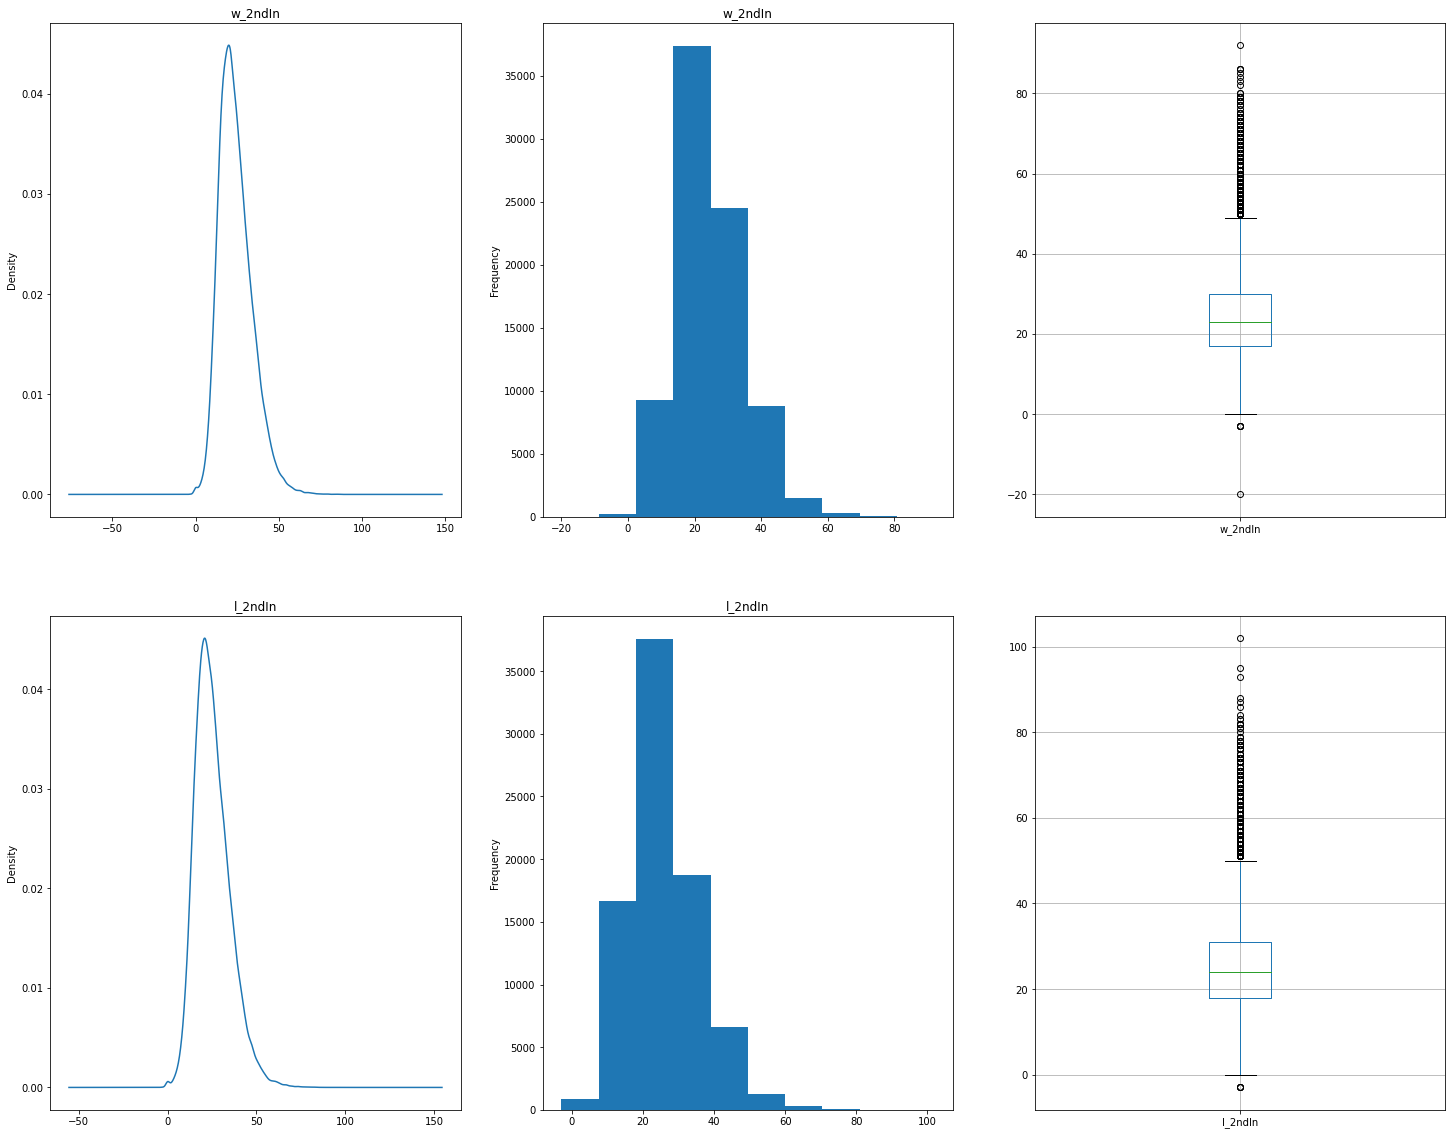

In [107]:
fig, axes = plt.subplots(2,3,figsize=(25,20))
matches['w_2ndIn'].plot(kind='kde', title='w_2ndIn', ax=axes[0][0])
matches['w_2ndIn'].plot(kind='hist', title='w_2ndIn', ax=axes[0][1])
matches.boxplot(column=['w_2ndIn'], ax=axes[0][2])

matches['l_2ndIn'].plot(kind='kde', title='l_2ndIn', ax=axes[1][0])
matches['l_2ndIn'].plot(kind='hist', title='l_2ndIn', ax=axes[1][1])
matches.boxplot(column=['l_2ndIn'], ax=axes[1][2])



plt.show()


### Tourney & Match importance

We discretize one between revenue and spectators (since they are correlated) to create a feature that represent the importance of the tourney.  
Moreover we can also include the round to increase the importance of the match based on it.

First we look at the distributions to find the best candidate to discretize.

In [108]:
matches[['tourney_id','tourney_revenue']].groupby(['tourney_id']).aggregate(max).reset_index()['tourney_revenue'].value_counts()

630526.35     1
1734432.78    1
1430477.15    1
979372.63     1
835568.54     1
             ..
700314.21     1
467577.16     1
623759.28     1
623968.01     1
105905.82     1
Name: tourney_revenue, Length: 1432, dtype: int64

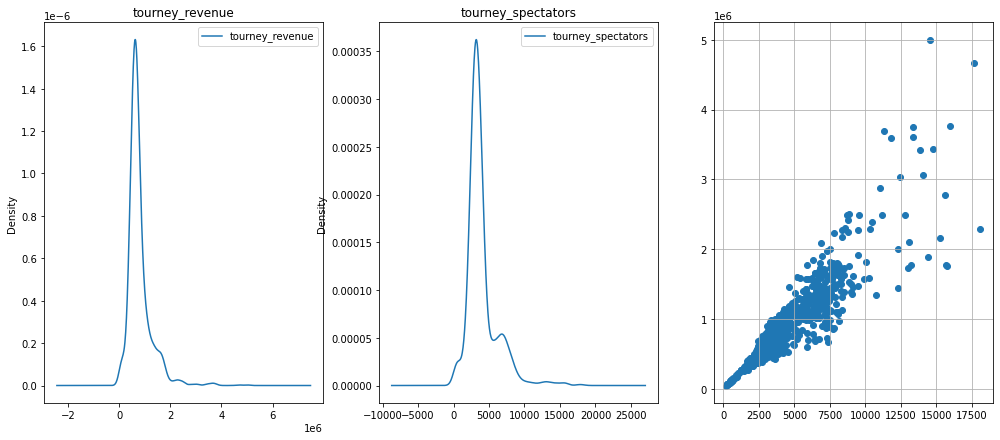

In [109]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3,figsize=(17,7))
matches[['tourney_id','tourney_revenue']].groupby(['tourney_id']).aggregate(max).reset_index()['tourney_revenue'].plot.kde(title="tourney_revenue", ax=ax1)
matches[['tourney_id','tourney_spectators']].groupby(['tourney_id']).aggregate(max).reset_index()['tourney_spectators'].plot.kde(title="tourney_spectators", ax=ax2)
plt.scatter(matches[['tourney_id','tourney_spectators']].groupby(['tourney_id']).aggregate(max).reset_index()['tourney_spectators'], 
            matches[['tourney_id','tourney_revenue']].groupby(['tourney_id']).aggregate(max).reset_index()['tourney_revenue'])
ax1.legend()
ax2.legend()
ax3.grid()
plt.show()



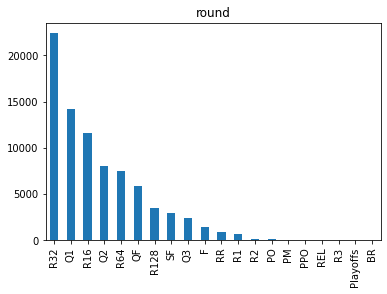

In [110]:
matches['round'].value_counts().plot(kind='bar',title='round')
plt.show()

In [111]:

[('F', 2),
 ('SF', 3),
 ('QF', 4),
 ('R16', 5),
 ('R32', 6),
 ('R64', 7),
 ('R128', 8),
 ('Q3', 9),
 ('Q2',10),
 ('Q1', 11),
 ('PO', 2.5),
 
]

[('F', 2),
 ('SF', 3),
 ('QF', 4),
 ('R16', 5),
 ('R32', 6),
 ('R64', 7),
 ('R128', 8),
 ('Q3', 9),
 ('Q2', 10),
 ('Q1', 11),
 ('PO', 2.5)]

In [112]:
#cost = matches[['tourney_id','tourney_revenue']].groupby(['tourney_id']).aggregate(max).reset_index()[['tourney_id','tourney_revenue']]
#cost.value_counts(bins=3, sort=False)
#cost['tourney_importnace'] = pd.cut(cost['tourney_revenue'], bins=3)
#cost.tourney_revenue.value_counts()
matches['tourney_importance'] = matches['tourney_revenue']

In [113]:
matches.head()

,best_of,draw_size,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_born_date,l_bpFaced,l_bpSaved,l_df,l_gender,l_svpt,loser_age,loser_entry,loser_hand,loser_ht,loser_id,loser_ioc,loser_name,loser_rank,loser_rank_points,match_num,minutes,round,score,surface,tid,tourney_date,tourney_id,tourney_level,tourney_name,tourney_revenue,tourney_spectators,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_ace,w_born_date,w_bpFaced,w_bpSaved,w_df,w_gender,w_svpt,winner_age,winner_entry,winner_hand,winner_ht,winner_id,winner_ioc,winner_name,winner_rank,winner_rank_points,n_sets,scoreapp,w_sets_won,w_games_won,l_games_won,l_sets_won,tiebreaks_total,tieapp,w_tb_won,l_tb_won,w_2ndIn,l_2ndIn,tourney_importance
0,3.0,32.0,54.0,34.0,20.0,14.0,8.0,1996.0,15.0,10.0,6.0,Male,100.0,22.885695,NaN,R,198.0,106421,RUS,daniil medvedev,16.0,1977.0,300.0,124.0,F,6-4 3-6 6-2,Hard,NaN,20181231.0,2019-M020,A,Brisbane,742618.69,3928.0,44.0,31.0,17.0,13.0,3.0,1990.0,6.0,3.0,3.0,Male,77.0,95.000000,NaN,R,178.0,105453,JPN,kei nishikori,9.0,3590.0,3,6-4 3-6 6-2,2,15,12,1,0,[],0,0,30.0,40.0,742618.69
1,3.0,32.0,52.0,36.0,7.0,10.0,17.0,1985.0,13.0,10.0,2.0,Male,77.0,33.705681,PR,R,188.0,104542,FRA,jo-wilfried tsonga,239.0,200.0,299.0,82.0,SF,7-6(6) 6-2,Hard,NaN,20181231.0,2019-M020,A,Brisbane,742618.69,3928.0,33.0,28.0,14.0,10.0,10.0,1996.0,1.0,0.0,1.0,Male,52.0,22.885695,NaN,R,198.0,106421,RUS,daniil medvedev,16.0,1977.0,2,7-6 6-2,2,13,8,0,1,[7-6(6)],1,0,18.0,23.0,742618.69
2,3.0,32.0,27.0,15.0,6.0,8.0,10.0,1987.0,5.0,1.0,3.0,Male,46.0,31.882272,NaN,R,188.0,104871,FRA,jeremy chardy,40.0,1050.0,298.0,66.0,SF,6-2 6-2,Hard,NaN,20181231.0,2019-M020,A,Brisbane,742618.69,3928.0,33.0,26.0,9.0,8.0,2.0,1990.0,2.0,2.0,2.0,Male,47.0,29.004791,NaN,R,178.0,105453,JPN,kei nishikori,9.0,3590.0,2,6-2 6-2,2,12,4,0,0,[],0,0,12.0,16.0,742618.69
3,3.0,32.0,60.0,38.0,9.0,11.0,1.0,1999.0,6.0,4.0,2.0,Male,81.0,19.868583,NaN,R,183.0,200282,AUS,alex de minaur,31.0,1298.0,297.0,106.0,QF,6-4 7-6(2),Hard,NaN,20181231.0,2019-M020,A,Brisbane,742618.69,3928.0,43.0,34.0,15.0,11.0,12.0,1985.0,5.0,4.0,2.0,Male,68.0,33.705681,PR,R,188.0,104542,FRA,jo-wilfried tsonga,239.0,200.0,2,6-4 7-6,2,13,10,0,1,[7-6(2)],1,0,23.0,19.0,742618.69
4,3.0,32.0,56.0,46.0,19.0,15.0,3.0,1991.0,4.0,2.0,5.0,Male,94.0,28.010951,NaN,R,196.0,105683,CAN,milos raonic,18.0,1855.0,296.0,129.0,QF,6-7(2) 6-3 6-4,Hard,NaN,20181231.0,2019-M020,A,Brisbane,742618.69,3928.0,68.0,48.0,25.0,16.0,12.0,1996.0,8.0,8.0,3.0,Male,105.0,22.885695,NaN,R,198.0,106421,RUS,daniil medvedev,16.0,1977.0,3,6-7 6-3 6-4,2,18,14,1,1,[6-7(2)],0,1,34.0,33.0,742618.69


## Players info

We create a dataframe to group all players so that we can do undestranding on players features without being bounded to matches

In [114]:
winners= matches[['winner_id', 'winner_name','w_born_date', 'w_gender', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'winner_rank','tourney_id']].rename(columns=lambda x: re.sub("^w[^_]*_","",x))
losers= matches[['loser_id', 'loser_name','l_born_date', 'l_gender', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'loser_rank','tourney_id']].rename(columns=lambda x: re.sub('l[^_]*_','',x))
m_players=pd.concat((winners, losers))
players = m_players.groupby('id').size().reset_index().drop([0], axis=1)
players.head()

,id
0,0200002
1,0200033
2,0200043
3,0200067
4,0200079


### Born Date

In [115]:
ages = m_players[m_players.born_date.notna()][['id','born_date']]
ages = ages[ages.born_date.notna()][['id','born_date']].groupby('id').agg(lambda x: x.value_counts().index.tolist()[0]).reset_index()
players = pd.merge(left=players,right=ages,how='left',on='id') #merge with ages

In [116]:
players.head()

,id,born_date
0,0200002,1982.0
1,0200033,1981.0
2,0200043,1983.0
3,0200067,1978.0
4,0200079,1983.0


#### Stats & Plots

In [117]:
players.born_date.describe()

count    4257.000000
mean     1994.395584
std         5.256124
min      1962.000000
25%      1991.000000
50%      1995.000000
75%      1998.000000
max      2007.000000
Name: born_date, dtype: float64

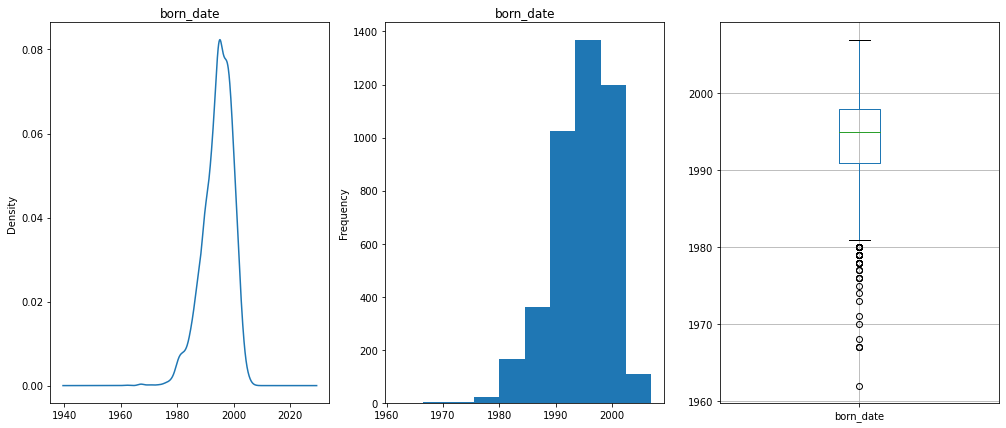

In [118]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(17,7))
players['born_date'].plot(kind='kde', title='born_date', ax=ax1)
players['born_date'].plot(kind='hist', title='born_date', ax=ax2)
players.boxplot(column=['born_date'], ax=ax3)
plt.show()

### Height

In [119]:
ht = m_players[m_players.ht.notna()][['id','ht']].groupby('id').agg(lambda x: x.value_counts().index.tolist()[0]).reset_index()
players = pd.merge(left=players,right=ht,how='left',on='id') #merge with ages

In [120]:
print(players['ht'].describe())

count    534.000000
mean     181.561798
std        8.807879
min      155.000000
25%      175.000000
50%      183.000000
75%      188.000000
max      211.000000
Name: ht, dtype: float64


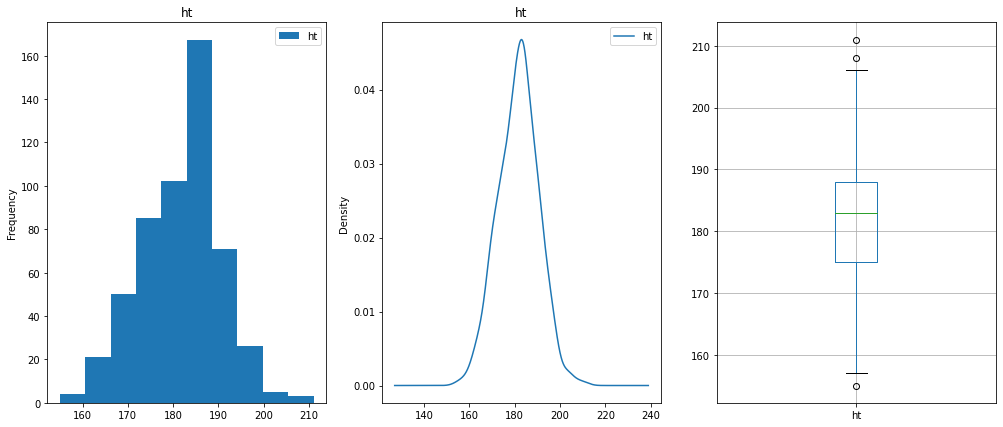

In [121]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(17,7))
players['ht'].plot.hist(title="ht", ax=ax1)
players['ht'].plot.kde(title="ht", ax=ax2)
players.boxplot(column=['ht'],ax=ax3)

ax1.legend()
ax2.legend()
plt.show()


### Rank

In [122]:
w_rank = matches.groupby('winner_id').agg({'loser_rank': 'min'}).reset_index()
w_rank = w_rank.rename(columns={'winner_id':'id', 'loser_rank':'o_rank'})
l_rank = matches.groupby('loser_id').agg({'winner_rank': 'min', }).reset_index()
l_rank = l_rank.rename(columns={'loser_id':'id',  'winner_rank':'o_rank'})
o_ranks_min = pd.concat([w_rank, l_rank])
o_ranks_min = o_ranks_min.groupby('id').agg({'o_rank': 'min'}).reset_index()

In [123]:
m_players.groupby('id').size().reset_index().shape

(4257, 2)

In [124]:
ranks_min = m_players[m_players['rank'].notna()].groupby('id').agg(frozenset).reset_index()
ranks_min[['id', 'rank']].shape

(3080, 2)

In [125]:
ranks_min = m_players.groupby('id').agg({'rank':'min'}).reset_index()
ranks_min[ranks_min['rank'].isna()].shape

(1177, 2)

In [126]:
players = pd.merge(left=players,right=ranks_min,how='left',on='id')
players = pd.merge(left=players,right=o_ranks_min,how='left',on='id')

#### Stats & Plots

In [127]:
print(players['rank'].describe())

count    3080.000000
mean      643.066234
std       537.011975
min         1.000000
25%       193.000000
50%       493.500000
75%       978.250000
max      2257.000000
Name: rank, dtype: float64


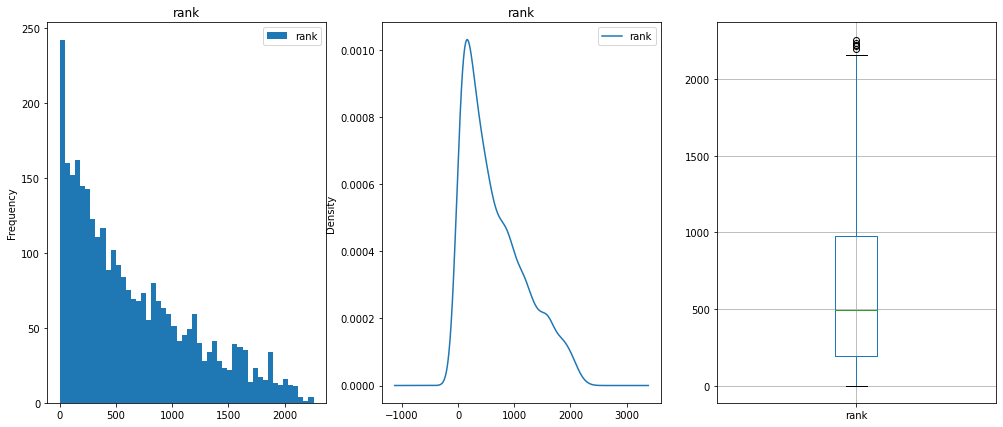

In [128]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(17,7))
players['rank'].plot.hist(title="rank", ax=ax1, bins=50)
players['rank'].plot.kde(title="rank", ax=ax2)
players.boxplot(column=['rank'],ax=ax3)

ax1.legend()
ax2.legend()
plt.show()

### Hands


In [129]:
hands = m_players.groupby('id').agg({'hand':'max'}).reset_index()
hands['hand'].fillna('U', inplace=True)
players = pd.merge(left=players,right=hands,how='left',on='id') 

In [130]:
print(players['hand'].describe())

count     4257
unique       3
top          R
freq      2135
Name: hand, dtype: object


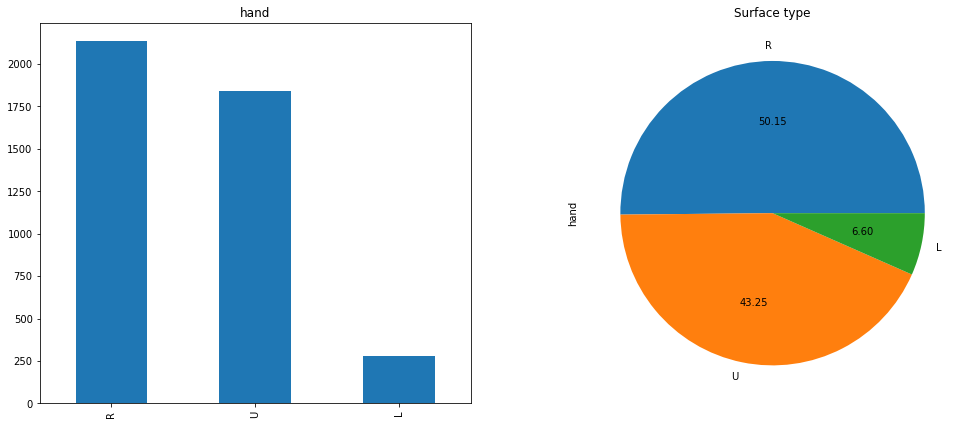

In [131]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(17,7))
players['hand'].value_counts().plot(kind='bar',title='hand', ax=ax1)
players['hand'].value_counts().plot(kind='pie', autopct='%.2f',title='Surface type',  ax=ax2)

plt.show()

### Gender


In [132]:
genders = m_players.groupby('id').agg({'gender':'max'}).reset_index()
players = pd.merge(left=players,right=genders,how='left',on='id') 

In [133]:
print(players['gender'].describe())

count     4257
unique       2
top       Male
freq      3005
Name: gender, dtype: object


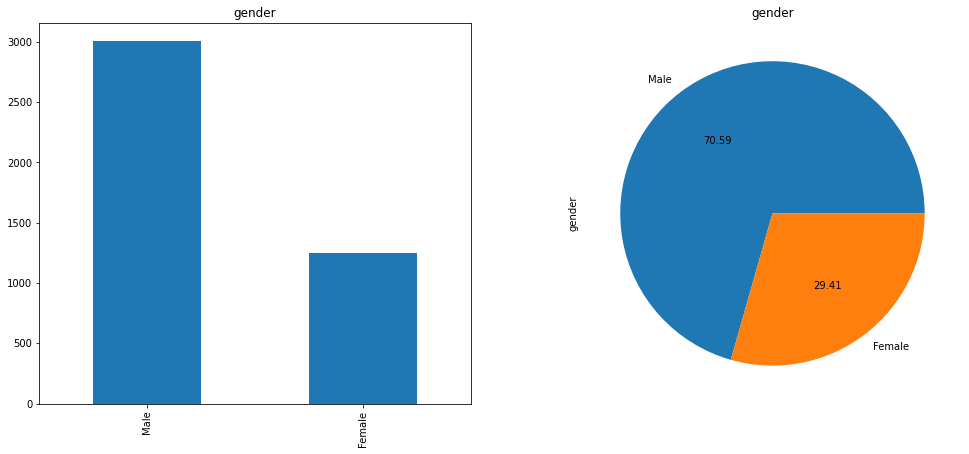

In [134]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(17,7))
players['gender'].value_counts().plot(kind='bar',title='gender', ax=ax1)
players['gender'].value_counts().plot(kind='pie', autopct='%.2f',title='gender',  ax=ax2)

plt.show()

### IOC

In [135]:
iocs = m_players.groupby('id').agg({'ioc':'max'}).reset_index()
players = pd.merge(left=players,right=iocs,how='left',on='id') 

In [136]:
print(players['ioc'].describe())

count     4257
unique     121
top        USA
freq       425
Name: ioc, dtype: object


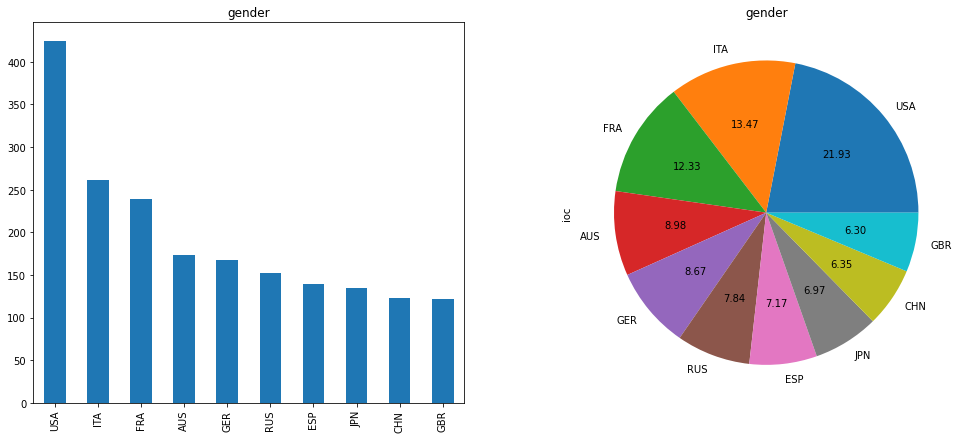

In [137]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(17,7))
players['ioc'].value_counts()[:10].plot(kind='bar',title='gender', ax=ax1)
players['ioc'].value_counts()[:10].plot(kind='pie', autopct='%.2f',title='gender',  ax=ax2)

plt.show()

## Overall player matches Stats

In [138]:
winners= matches[['winner_id', 'winner_name','w_born_date', 'w_gender', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'winner_rank','tourney_id', 'tourney_importance']].rename(columns=lambda x: re.sub("^w[^_]*_","",x))
losers= matches[['loser_id', 'loser_name','l_born_date', 'l_gender', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'loser_rank','tourney_id', 'tourney_importance']].rename(columns=lambda x: re.sub('l[^_]*_','',x))
m_players=pd.concat((winners, losers))
players_stats = m_players.groupby('id').size().reset_index().drop([0], axis=1)
print(players_stats.shape)
players_stats.head()

(4257, 1)


,id
0,0200002
1,0200033
2,0200043
3,0200067
4,0200079


### Matches on surfaces

In [139]:

# surfaces
surfaces = pd.concat((matches, pd.get_dummies(matches.surface)), axis=1)
w_surf = surfaces[['winner_id', 'Clay', 'Hard', 'Carpet', 'Grass']].rename({'winner_id':'id'}, axis=1)
l_surf = surfaces[['loser_id', 'Clay', 'Hard', 'Carpet', 'Grass']].rename({'loser_id':'id'}, axis=1)
t_surf = pd.concat((w_surf, l_surf)).groupby('id').sum().reset_index()
w_surf = w_surf.rename({'winner_id':'id', 'Clay':'w_clay', 'Hard':'w_hard', 'Carpet':'w_carpet', 'Grass':'w_grass'}, axis=1).groupby('id').sum().reset_index()

players_stats = pd.merge(players_stats, w_surf, on='id', how='left')
players_stats = pd.merge(players_stats, t_surf, on='id', how='left')

players_stats[['w_clay', 'w_hard','w_carpet','w_grass', 'Clay', 'Hard', 'Carpet', 'Grass']]=players_stats[['w_clay', 'w_hard','w_carpet','w_grass', 'Clay', 'Hard', 'Carpet', 'Grass']].fillna(0) # se non hanno nessuna vittoria


In [140]:
print(players_stats.shape)
players_stats.head()

(4257, 9)


,id,w_clay,w_hard,w_carpet,w_grass,Clay,Hard,Carpet,Grass
0,0200002,18.0,26.0,0.0,3.0,28.0,51.0,0.0,9.0
1,0200033,22.0,77.0,0.0,19.0,27.0,99.0,0.0,22.0
2,0200043,11.0,0.0,0.0,0.0,21.0,4.0,0.0,0.0
3,0200067,5.0,7.0,0.0,0.0,12.0,13.0,0.0,0.0
4,0200079,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0


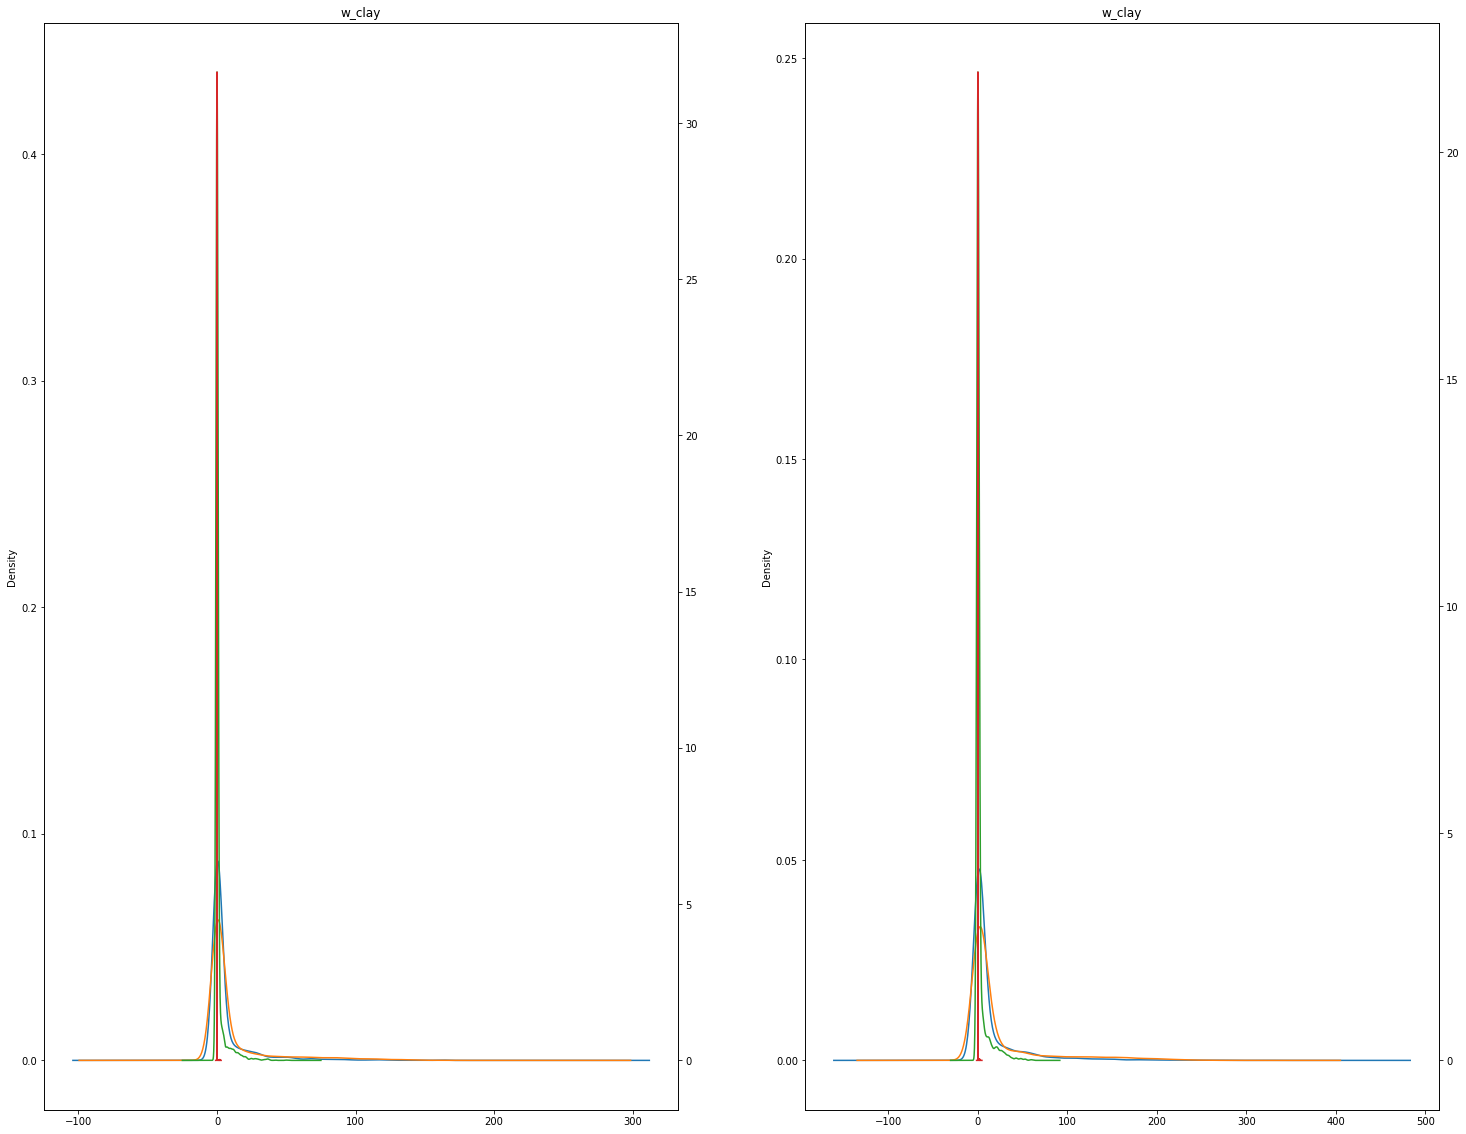

In [141]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,20))
players_stats['w_clay'].plot(kind='kde', title='w_clay', ax=ax1)
players_stats['w_hard'].plot(kind='kde', title='w_clay', ax=ax1)
players_stats['w_grass'].plot(kind='kde', title='w_clay', ax=ax1)
players_stats['w_carpet'].plot(kind='kde', title='w_clay', ax=ax1, secondary_y= True)

#players_stats['w_clay'].plot(kind='hist', title='w_clay', ax=axes[0][1])
#players_stats.boxplot(column=['w_clay'], ax=axes[0][2])

players_stats['Clay'].plot(kind='kde', title='w_clay', ax=ax2)
players_stats['Hard'].plot(kind='kde', title='w_clay', ax=ax2)
players_stats['Grass'].plot(kind='kde', title='w_clay', ax=ax2)
players_stats['Carpet'].plot(kind='kde', title='w_clay', ax=ax2, secondary_y= True)



plt.show()

### Tourney

In [142]:

# Number of won torney
won_tourney = matches[matches['round']=='F'].groupby('winner_id')['tourney_id'].count().reset_index(name='tourney_win').sort_values(by='tourney_win',ascending=False).rename(columns={'winner_id':'id'})
players_stats = pd.merge(players_stats, won_tourney, on='id', how='left')
players_stats['tourney_win'] = players_stats['tourney_win'].fillna(0) # never won

#tourney count
t_win_count = matches.groupby(['winner_id', 'tourney_id']).size().reset_index(name='count').rename(columns={'winner_id':'id'})
t_l_count = matches.groupby(['loser_id', 'tourney_id']).size().reset_index(name='count').rename(columns={'loser_id':'id'})
t_count = pd.concat((t_win_count, t_l_count)).drop('count', axis=1).drop_duplicates()
t_count = t_count.groupby('id').size().reset_index(name='tourney_count')
players_stats = pd.merge(players_stats, t_count,  how='left', on='id')


In [143]:
print(players_stats.shape)
players_stats.head()

(4257, 11)


,id,w_clay,w_hard,w_carpet,w_grass,Clay,Hard,Carpet,Grass,tourney_win,tourney_count
0,0200002,18.0,26.0,0.0,3.0,28.0,51.0,0.0,9.0,0.0,41
1,0200033,22.0,77.0,0.0,19.0,27.0,99.0,0.0,22.0,4.0,38
2,0200043,11.0,0.0,0.0,0.0,21.0,4.0,0.0,0.0,0.0,13
3,0200067,5.0,7.0,0.0,0.0,12.0,13.0,0.0,0.0,0.0,13
4,0200079,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3


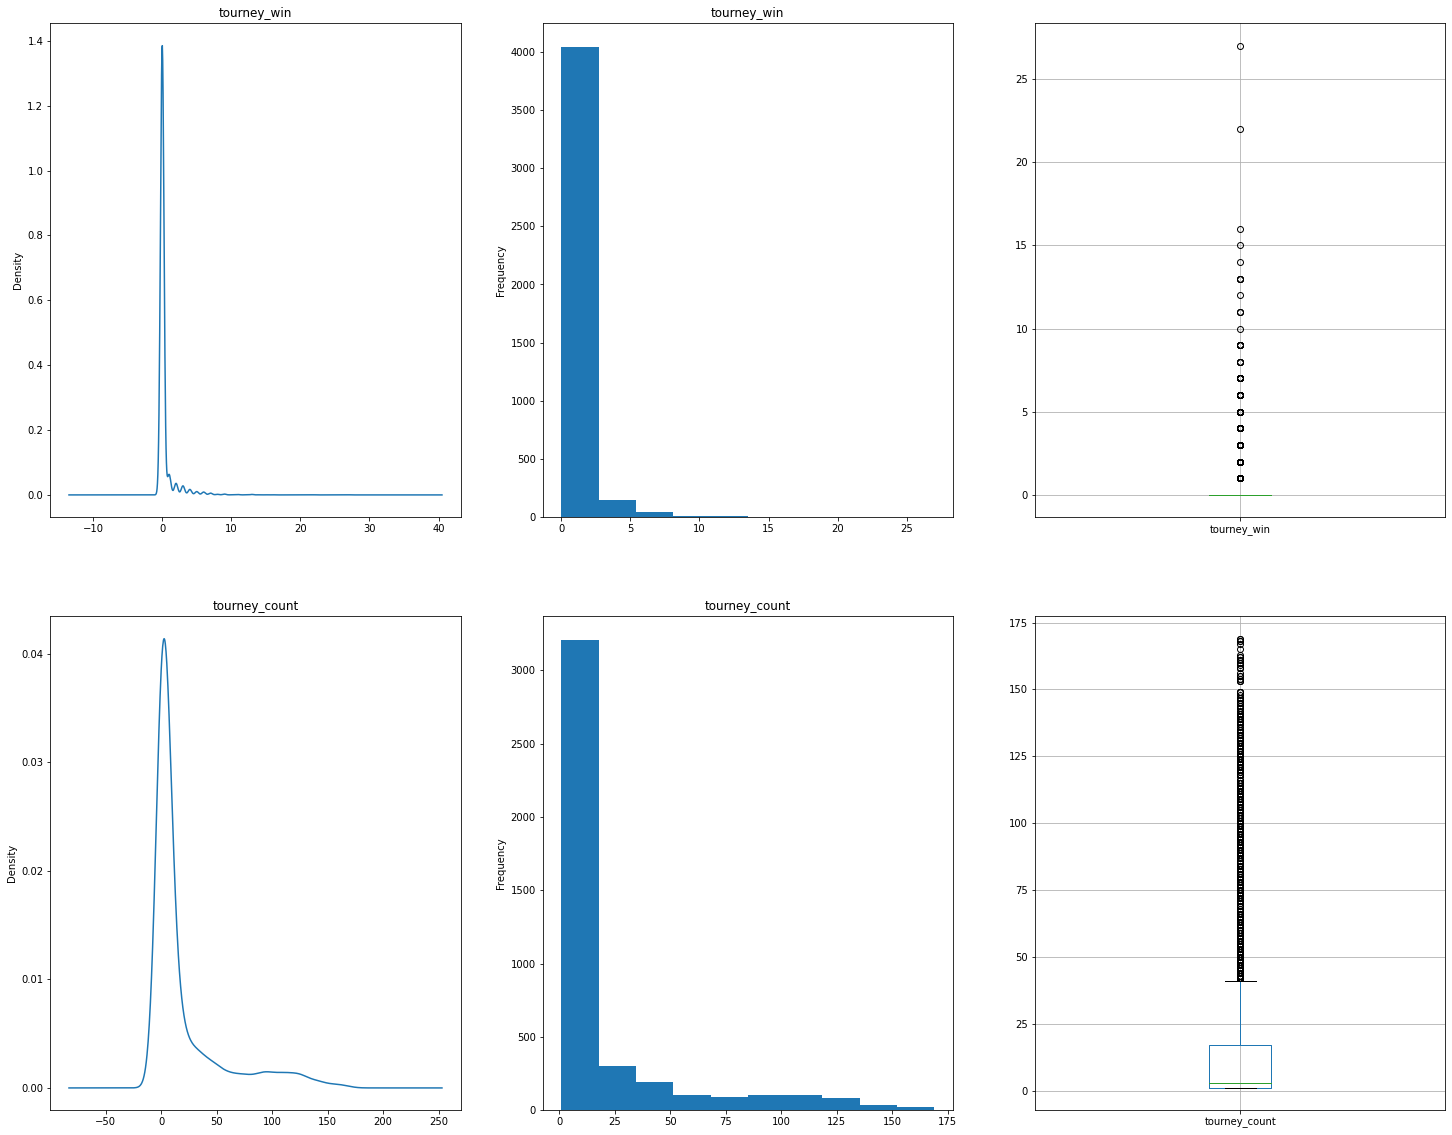

In [144]:
fig, axes = plt.subplots(2,3,figsize=(25,20))
players_stats['tourney_win'].plot(kind='kde', title='tourney_win', ax=axes[0][0])
players_stats['tourney_win'].plot(kind='hist', title='tourney_win', ax=axes[0][1])
players_stats.boxplot(column=['tourney_win'], ax=axes[0][2])

players_stats['tourney_count'].plot(kind='kde', title='tourney_count', ax=axes[1][0])
players_stats['tourney_count'].plot(kind='hist', title='tourney_count', ax=axes[1][1])
players_stats.boxplot(column=['tourney_count'], ax=axes[1][2])



plt.show()


### Counting matches

In [145]:
# Numer of won matches
win_count = matches.groupby('winner_id').size().reset_index(name='match_win').rename(columns={'winner_id':'id'})

# Numer of lost matches
l_count = matches.groupby('loser_id').size().reset_index(name='match_lost').rename(columns={'loser_id':'id'})

# Match count
match_count = pd.merge(l_count, win_count,  how='outer', left_on=['id'], right_on = ['id'])
match_count[['match_win','match_lost']] = match_count[['match_win','match_lost']].fillna(0)
match_count['match_count'] = match_count['match_win'] + match_count['match_lost']

players_stats = pd.merge(players_stats, match_count,  how='left', left_on=['id'], right_on = ['id'])


In [146]:
print(players_stats.shape)
players_stats.head()

(4257, 14)


,id,w_clay,w_hard,w_carpet,w_grass,Clay,Hard,Carpet,Grass,tourney_win,tourney_count,match_lost,match_win,match_count
0,0200002,18.0,26.0,0.0,3.0,28.0,51.0,0.0,9.0,0.0,41,41.0,47.0,88.0
1,0200033,22.0,77.0,0.0,19.0,27.0,99.0,0.0,22.0,4.0,38,30.0,118.0,148.0
2,0200043,11.0,0.0,0.0,0.0,21.0,4.0,0.0,0.0,0.0,13,14.0,11.0,25.0
3,0200067,5.0,7.0,0.0,0.0,12.0,13.0,0.0,0.0,0.0,13,13.0,12.0,25.0
4,0200079,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3,3.0,0.0,3.0


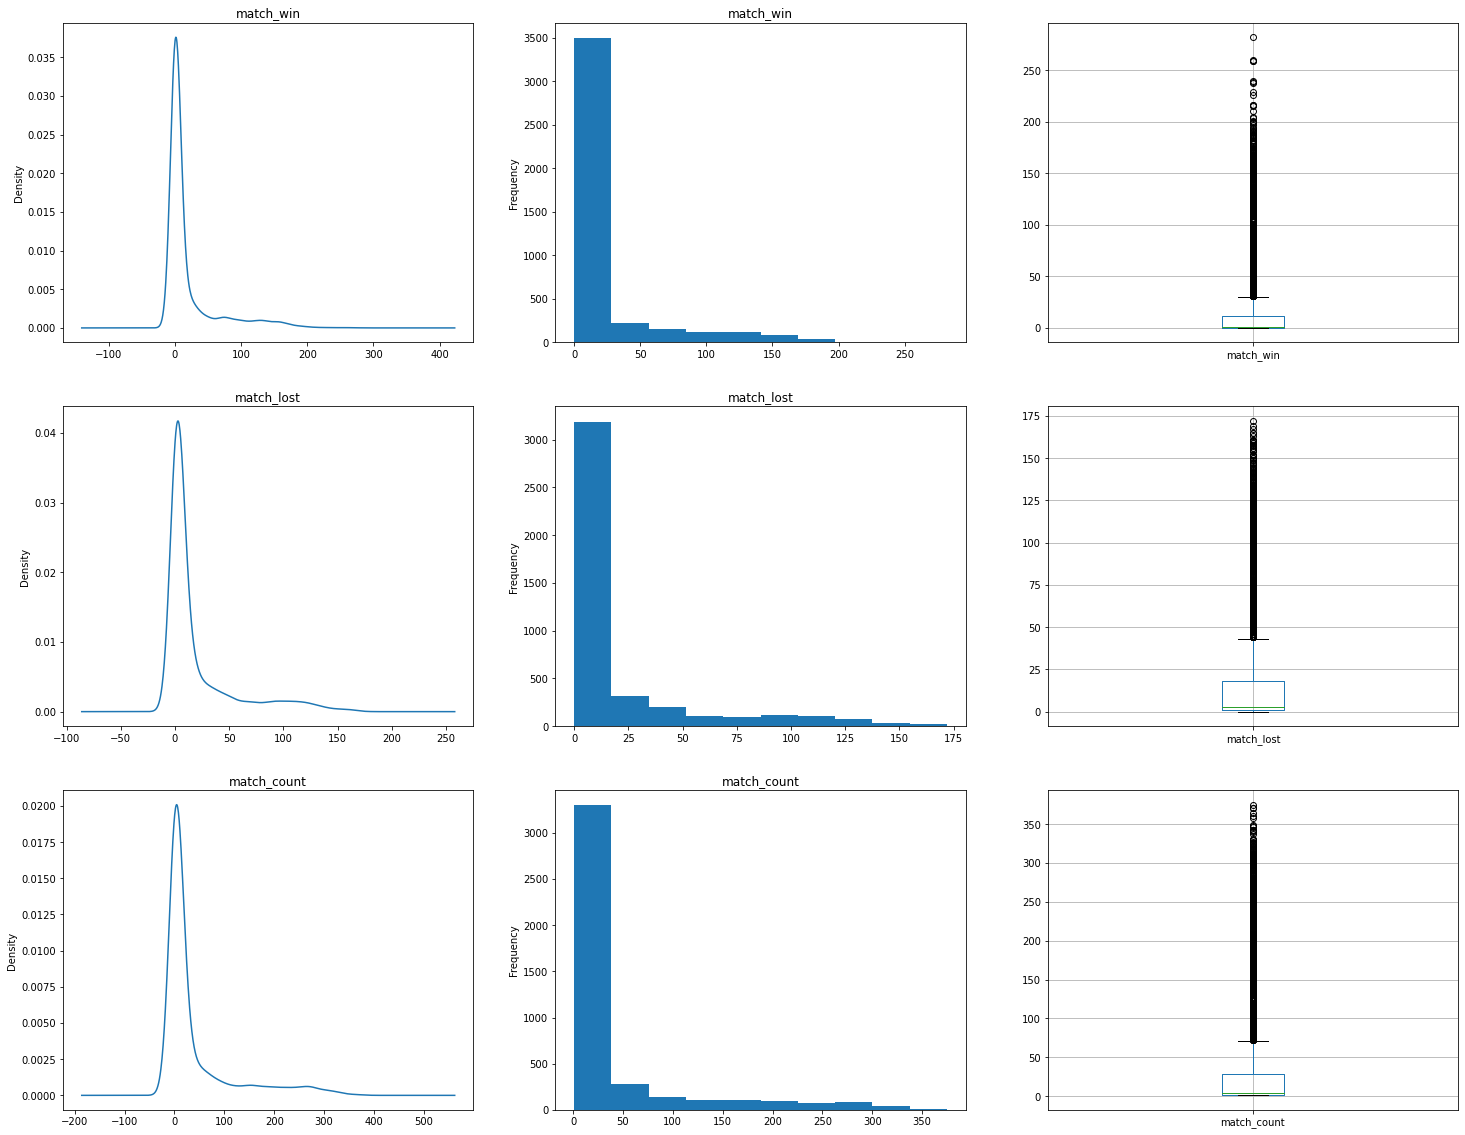

In [147]:
fig, axes = plt.subplots(3,3,figsize=(25,20))
players_stats['match_win'].plot(kind='kde', title='match_win', ax=axes[0][0])
players_stats['match_win'].plot(kind='hist', title='match_win', ax=axes[0][1])
players_stats.boxplot(column=['match_win'], ax=axes[0][2])

players_stats['match_lost'].plot(kind='kde', title='match_lost', ax=axes[1][0])
players_stats['match_lost'].plot(kind='hist', title='match_lost', ax=axes[1][1])
players_stats.boxplot(column=['match_lost'], ax=axes[1][2])

players_stats['match_count'].plot(kind='kde', title='match_count', ax=axes[2][0])
players_stats['match_count'].plot(kind='hist', title='match_count', ax=axes[2][1])
players_stats.boxplot(column=['match_count'], ax=axes[2][2])



plt.show()


### Stats sums aggregation


In [148]:
#sums
w_sums = matches.groupby('winner_id').sum().reset_index()
l_sums = matches.groupby('loser_id').sum().reset_index()

w_sums.columns= w_sums.columns.str.replace(r'^w_', '', regex=True) 
w_sums.columns= w_sums.columns.str.replace(r'^l_', 'o_', regex=True)
w_sums = w_sums.rename(columns={'winner_id':'id'})

l_sums.columns = l_sums.columns.str.replace(r'^l_', '', regex=True)
l_sums.columns = l_sums.columns.str.replace(r'^w_', 'o_', regex=True)
l_sums = l_sums.rename(columns={'loser_id':'id'})

sums = pd.concat([w_sums, l_sums])
sums = sums.groupby('id').sum()
sums.drop(['draw_size', 'tourney_date', 'match_num', 'winner_ht', 'winner_age', 'loser_ht', 'loser_age', 'best_of', 'winner_rank', 'loser_rank', 'winner_rank_points', 'loser_rank_points', 'tourney_revenue', 'tourney_spectators', 'born_date', 'o_born_date'], axis=1, inplace=True) 

players_stats = pd.merge(players_stats, sums, on='id', how='left')


In [149]:
print(players_stats.shape[0])
players_stats.head()

4257


,id,w_clay,w_hard,w_carpet,w_grass,Clay,Hard,Carpet,Grass,tourney_win,tourney_count,match_lost,match_win,match_count,o_1stIn,o_1stWon,o_2ndWon,o_SvGms,o_ace,o_bpFaced,o_bpSaved,o_df,o_svpt,minutes,1stIn,1stWon,2ndWon,SvGms,ace,bpFaced,bpSaved,df,svpt,n_sets,sets_won,games_won,o_games_won,o_sets_won,tiebreaks_total,tb_won,o_tb_won,2ndIn,o_2ndIn,tourney_importance
0,0200002,18.0,26.0,0.0,3.0,28.0,51.0,0.0,9.0,0.0,41,41.0,47.0,88.0,3689.0,2248.0,1026.0,873.0,245.0,728.0,354.0,340.0,6060.0,7728.0,3636.0,2367.0,1167.0,884.0,269.0,772.0,414.0,536.0,6417.0,206,107,967,924,99,17,8,9,2245.0,2031.0,1.128585e+08
1,0200033,22.0,77.0,0.0,19.0,27.0,99.0,0.0,22.0,4.0,38,30.0,118.0,148.0,5940.0,3677.0,1623.0,1449.0,417.0,1248.0,683.0,534.0,9726.0,12903.0,5497.0,4100.0,1836.0,1494.0,1044.0,727.0,437.0,445.0,9261.0,326,247,1794,1193,79,29,19,10,3319.0,3252.0,2.984865e+08
2,0200043,11.0,0.0,0.0,0.0,21.0,4.0,0.0,0.0,0.0,13,14.0,11.0,25.0,1014.0,622.0,296.0,262.0,61.0,192.0,91.0,97.0,1647.0,2312.0,1106.0,667.0,241.0,260.0,51.0,226.0,112.0,120.0,1716.0,60,29,252,274,31,4,4,0,490.0,536.0,1.790654e+07
3,0200067,5.0,7.0,0.0,0.0,12.0,13.0,0.0,0.0,0.0,13,13.0,12.0,25.0,1153.0,741.0,343.0,247.0,76.0,231.0,132.0,119.0,1906.0,2312.0,1214.0,752.0,308.0,248.0,43.0,197.0,106.0,51.0,1811.0,61,29,296,282,32,8,2,6,546.0,634.0,2.295915e+07
4,0200079,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3,3.0,0.0,3.0,150.0,111.0,37.0,34.0,20.0,20.0,15.0,12.0,227.0,288.0,164.0,102.0,35.0,35.0,16.0,33.0,21.0,20.0,244.0,7,1,28,42,6,1,0,1,60.0,65.0,2.826429e+06


### Mean tourney importance

In [150]:
#mean tourney importance
players_stats['mean_tourney_importance'] = players_stats['tourney_importance'] / players_stats['match_count']

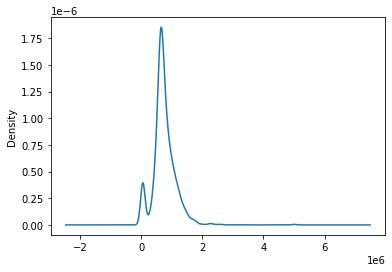

In [151]:
players_stats['mean_tourney_importance'].plot.kde()

### Win percentage on surfaces

In [152]:
players_stats['%w_clay'] = players_stats['w_clay']/players_stats['Clay']
players_stats['%w_hard'] = players_stats['w_hard']/players_stats['Hard']
players_stats['%w_grass'] = players_stats['w_grass']/players_stats['Grass']
players_stats['%w_carpet'] = players_stats['w_carpet']/players_stats['Carpet']


#### Understanding


### Win percentatage

In [153]:
players_stats['%wins'] = players_stats['match_win']/players_stats['match_count']

### First serve win percentage

In [154]:
players_stats['%fsw'] = players_stats['1stWon']/ players_stats['1stIn']

### Second serve win percentage

In [155]:
players_stats['%ssw'] = players_stats['2ndWon']/ players_stats['2ndIn']

### Ace percentage

In [156]:
players_stats['%ace'] = players_stats['ace']/ players_stats['svpt']

### Double fault percentage

In [157]:
players_stats['%df'] = players_stats['df']/ players_stats['svpt']

### Games per match


In [158]:
players_stats['gpm'] = (players_stats['games_won'] + players_stats['o_games_won'] )/ players_stats['match_count']

### Tiebreaks won percentage


In [159]:
players_stats['%tb_won'] = players_stats['tb_won']/ players_stats['tiebreaks_total']


### Breakpoint saved percentage

In [160]:
players_stats['%bp_saved'] = players_stats['bpSaved']/ players_stats['bpFaced']


### Successful 1 serve percentage

In [161]:
players_stats['%succ1serve'] = players_stats['1stIn']/ players_stats['svpt']


### 1st serve return point won


In [162]:

players_stats['1st_srp_won'] = players_stats['o_1stIn'] - players_stats['o_1stWon']
players_stats['%1st_srp_won'] = players_stats['1st_srp_won'] / players_stats['o_1stIn']  


### 2nd serve return point won

In [163]:
players_stats['2nd_srp_won'] = players_stats['o_2ndIn'] - players_stats['o_2ndWon'] 
players_stats['%2nd_srp_won'] = players_stats['2nd_srp_won'] / players_stats['o_2ndIn'] 


### Breakpoint won percentage


In [164]:
players_stats['bp_won'] = players_stats['o_bpFaced'] - players_stats['o_bpSaved'] #break point won
players_stats['%bp_won'] = players_stats['bp_won'] / players_stats['o_bpFaced'] #break point won


### Minutes per match

In [165]:
players_stats['minutes_x_match'] = players_stats['minutes'] / players_stats['match_count'] #break point won


# Missing values

abbiamo dei nan dovuti alla divisione 0/0, rimpiazziamo quindi con 0

In [166]:
players_stats[list(filter(lambda x: '%' in x,players_stats.columns.values))] = players_stats[filter(lambda x: '%' in x,players_stats.columns.values)].fillna(0)


In [167]:
players_stats.head()

,id,w_clay,w_hard,w_carpet,w_grass,Clay,Hard,Carpet,Grass,tourney_win,tourney_count,match_lost,match_win,match_count,o_1stIn,o_1stWon,o_2ndWon,o_SvGms,o_ace,o_bpFaced,o_bpSaved,o_df,o_svpt,minutes,1stIn,1stWon,2ndWon,SvGms,ace,bpFaced,bpSaved,df,svpt,n_sets,sets_won,games_won,o_games_won,o_sets_won,tiebreaks_total,tb_won,o_tb_won,2ndIn,o_2ndIn,tourney_importance,mean_tourney_importance,%w_clay,%w_hard,%w_grass,%w_carpet,%wins,%fsw,%ssw,%ace,%df,gpm,%tb_won,%bp_saved,%succ1serve,1st_srp_won,%1st_srp_won,2nd_srp_won,%2nd_srp_won,bp_won,%bp_won,minutes_x_match
0,0200002,18.0,26.0,0.0,3.0,28.0,51.0,0.0,9.0,0.0,41,41.0,47.0,88.0,3689.0,2248.0,1026.0,873.0,245.0,728.0,354.0,340.0,6060.0,7728.0,3636.0,2367.0,1167.0,884.0,269.0,772.0,414.0,536.0,6417.0,206,107,967,924,99,17,8,9,2245.0,2031.0,1.128585e+08,1.282483e+06,0.642857,0.509804,0.333333,0.0,0.534091,0.650990,0.519822,0.041920,0.083528,21.488636,0.470588,0.536269,0.566620,1441.0,0.390621,1005.0,0.494830,374.0,0.513736,87.818182
1,0200033,22.0,77.0,0.0,19.0,27.0,99.0,0.0,22.0,4.0,38,30.0,118.0,148.0,5940.0,3677.0,1623.0,1449.0,417.0,1248.0,683.0,534.0,9726.0,12903.0,5497.0,4100.0,1836.0,1494.0,1044.0,727.0,437.0,445.0,9261.0,326,247,1794,1193,79,29,19,10,3319.0,3252.0,2.984865e+08,2.016801e+06,0.814815,0.777778,0.863636,0.0,0.797297,0.745861,0.553179,0.112731,0.048051,20.182432,0.655172,0.601100,0.593564,2263.0,0.380976,1629.0,0.500923,565.0,0.452724,87.182432
2,0200043,11.0,0.0,0.0,0.0,21.0,4.0,0.0,0.0,0.0,13,14.0,11.0,25.0,1014.0,622.0,296.0,262.0,61.0,192.0,91.0,97.0,1647.0,2312.0,1106.0,667.0,241.0,260.0,51.0,226.0,112.0,120.0,1716.0,60,29,252,274,31,4,4,0,490.0,536.0,1.790654e+07,7.162616e+05,0.523810,0.000000,0.000000,0.0,0.440000,0.603074,0.491837,0.029720,0.069930,21.040000,1.000000,0.495575,0.644522,392.0,0.386588,240.0,0.447761,101.0,0.526042,92.480000
3,0200067,5.0,7.0,0.0,0.0,12.0,13.0,0.0,0.0,0.0,13,13.0,12.0,25.0,1153.0,741.0,343.0,247.0,76.0,231.0,132.0,119.0,1906.0,2312.0,1214.0,752.0,308.0,248.0,43.0,197.0,106.0,51.0,1811.0,61,29,296,282,32,8,2,6,546.0,634.0,2.295915e+07,9.183661e+05,0.416667,0.538462,0.000000,0.0,0.480000,0.619440,0.564103,0.023744,0.028161,23.120000,0.250000,0.538071,0.670348,412.0,0.357329,291.0,0.458991,99.0,0.428571,92.480000
4,0200079,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3,3.0,0.0,3.0,150.0,111.0,37.0,34.0,20.0,20.0,15.0,12.0,227.0,288.0,164.0,102.0,35.0,35.0,16.0,33.0,21.0,20.0,244.0,7,1,28,42,6,1,0,1,60.0,65.0,2.826429e+06,9.421430e+05,0.000000,0.000000,0.000000,0.0,0.000000,0.621951,0.583333,0.065574,0.081967,23.333333,0.000000,0.636364,0.672131,39.0,0.260000,28.0,0.430769,5.0,0.250000,96.000000


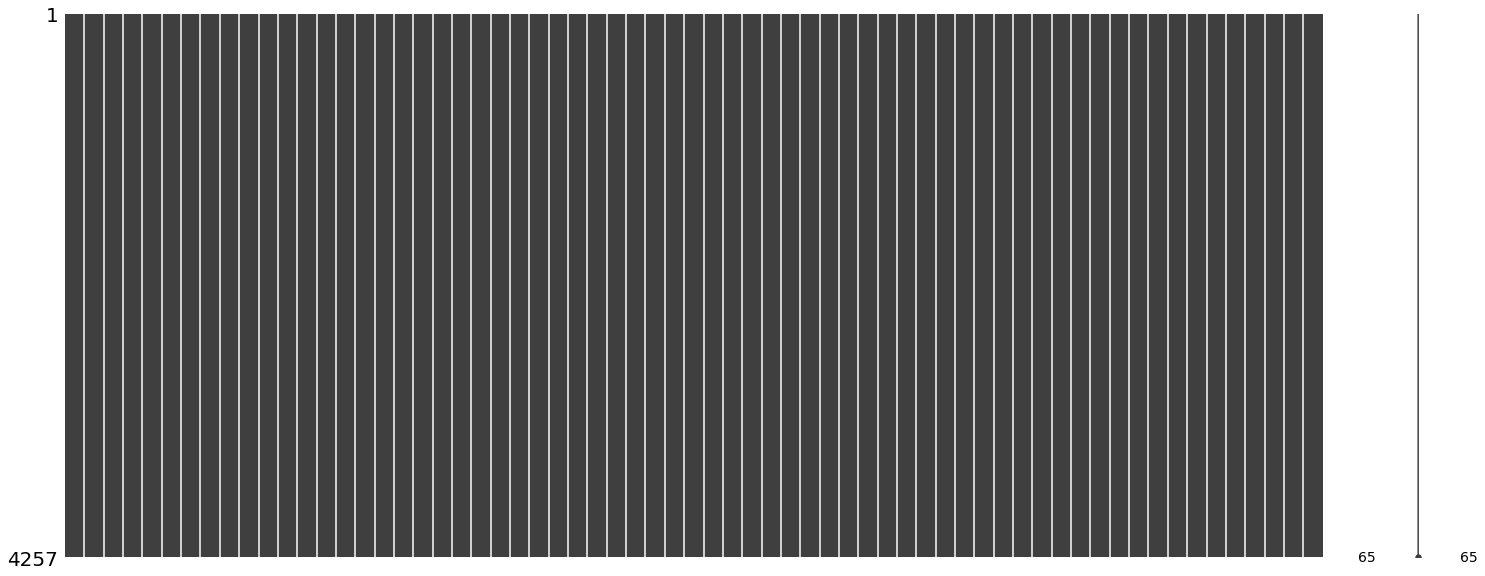

In [168]:
import missingno as msno
msno.matrix(players_stats)
plt.show()

In [169]:
players_stats.head()

,id,w_clay,w_hard,w_carpet,w_grass,Clay,Hard,Carpet,Grass,tourney_win,tourney_count,match_lost,match_win,match_count,o_1stIn,o_1stWon,o_2ndWon,o_SvGms,o_ace,o_bpFaced,o_bpSaved,o_df,o_svpt,minutes,1stIn,1stWon,2ndWon,SvGms,ace,bpFaced,bpSaved,df,svpt,n_sets,sets_won,games_won,o_games_won,o_sets_won,tiebreaks_total,tb_won,o_tb_won,2ndIn,o_2ndIn,tourney_importance,mean_tourney_importance,%w_clay,%w_hard,%w_grass,%w_carpet,%wins,%fsw,%ssw,%ace,%df,gpm,%tb_won,%bp_saved,%succ1serve,1st_srp_won,%1st_srp_won,2nd_srp_won,%2nd_srp_won,bp_won,%bp_won,minutes_x_match
0,0200002,18.0,26.0,0.0,3.0,28.0,51.0,0.0,9.0,0.0,41,41.0,47.0,88.0,3689.0,2248.0,1026.0,873.0,245.0,728.0,354.0,340.0,6060.0,7728.0,3636.0,2367.0,1167.0,884.0,269.0,772.0,414.0,536.0,6417.0,206,107,967,924,99,17,8,9,2245.0,2031.0,1.128585e+08,1.282483e+06,0.642857,0.509804,0.333333,0.0,0.534091,0.650990,0.519822,0.041920,0.083528,21.488636,0.470588,0.536269,0.566620,1441.0,0.390621,1005.0,0.494830,374.0,0.513736,87.818182
1,0200033,22.0,77.0,0.0,19.0,27.0,99.0,0.0,22.0,4.0,38,30.0,118.0,148.0,5940.0,3677.0,1623.0,1449.0,417.0,1248.0,683.0,534.0,9726.0,12903.0,5497.0,4100.0,1836.0,1494.0,1044.0,727.0,437.0,445.0,9261.0,326,247,1794,1193,79,29,19,10,3319.0,3252.0,2.984865e+08,2.016801e+06,0.814815,0.777778,0.863636,0.0,0.797297,0.745861,0.553179,0.112731,0.048051,20.182432,0.655172,0.601100,0.593564,2263.0,0.380976,1629.0,0.500923,565.0,0.452724,87.182432
2,0200043,11.0,0.0,0.0,0.0,21.0,4.0,0.0,0.0,0.0,13,14.0,11.0,25.0,1014.0,622.0,296.0,262.0,61.0,192.0,91.0,97.0,1647.0,2312.0,1106.0,667.0,241.0,260.0,51.0,226.0,112.0,120.0,1716.0,60,29,252,274,31,4,4,0,490.0,536.0,1.790654e+07,7.162616e+05,0.523810,0.000000,0.000000,0.0,0.440000,0.603074,0.491837,0.029720,0.069930,21.040000,1.000000,0.495575,0.644522,392.0,0.386588,240.0,0.447761,101.0,0.526042,92.480000
3,0200067,5.0,7.0,0.0,0.0,12.0,13.0,0.0,0.0,0.0,13,13.0,12.0,25.0,1153.0,741.0,343.0,247.0,76.0,231.0,132.0,119.0,1906.0,2312.0,1214.0,752.0,308.0,248.0,43.0,197.0,106.0,51.0,1811.0,61,29,296,282,32,8,2,6,546.0,634.0,2.295915e+07,9.183661e+05,0.416667,0.538462,0.000000,0.0,0.480000,0.619440,0.564103,0.023744,0.028161,23.120000,0.250000,0.538071,0.670348,412.0,0.357329,291.0,0.458991,99.0,0.428571,92.480000
4,0200079,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3,3.0,0.0,3.0,150.0,111.0,37.0,34.0,20.0,20.0,15.0,12.0,227.0,288.0,164.0,102.0,35.0,35.0,16.0,33.0,21.0,20.0,244.0,7,1,28,42,6,1,0,1,60.0,65.0,2.826429e+06,9.421430e+05,0.000000,0.000000,0.000000,0.0,0.000000,0.621951,0.583333,0.065574,0.081967,23.333333,0.000000,0.636364,0.672131,39.0,0.260000,28.0,0.430769,5.0,0.250000,96.000000


## Merging players and stats

In [170]:
players = pd.merge(players, players_stats,left_on='id',right_on='id', how='inner')
print(players.shape[0])
players.head()

4257


,id,born_date,ht,rank,o_rank,hand,gender,ioc,w_clay,w_hard,w_carpet,w_grass,Clay,Hard,Carpet,Grass,tourney_win,tourney_count,match_lost,match_win,match_count,o_1stIn,o_1stWon,o_2ndWon,o_SvGms,o_ace,o_bpFaced,o_bpSaved,o_df,o_svpt,minutes,1stIn,1stWon,2ndWon,SvGms,ace,bpFaced,bpSaved,df,svpt,n_sets,sets_won,games_won,o_games_won,o_sets_won,tiebreaks_total,tb_won,o_tb_won,2ndIn,o_2ndIn,tourney_importance,mean_tourney_importance,%w_clay,%w_hard,%w_grass,%w_carpet,%wins,%fsw,%ssw,%ace,%df,gpm,%tb_won,%bp_saved,%succ1serve,1st_srp_won,%1st_srp_won,2nd_srp_won,%2nd_srp_won,bp_won,%bp_won,minutes_x_match
0,0200002,1982.0,NaN,21.0,2.0,R,Female,CRO,18.0,26.0,0.0,3.0,28.0,51.0,0.0,9.0,0.0,41,41.0,47.0,88.0,3689.0,2248.0,1026.0,873.0,245.0,728.0,354.0,340.0,6060.0,7728.0,3636.0,2367.0,1167.0,884.0,269.0,772.0,414.0,536.0,6417.0,206,107,967,924,99,17,8,9,2245.0,2031.0,1.128585e+08,1.282483e+06,0.642857,0.509804,0.333333,0.0,0.534091,0.650990,0.519822,0.041920,0.083528,21.488636,0.470588,0.536269,0.566620,1441.0,0.390621,1005.0,0.494830,374.0,0.513736,87.818182
1,0200033,1981.0,175.0,1.0,1.0,R,Female,USA,22.0,77.0,0.0,19.0,27.0,99.0,0.0,22.0,4.0,38,30.0,118.0,148.0,5940.0,3677.0,1623.0,1449.0,417.0,1248.0,683.0,534.0,9726.0,12903.0,5497.0,4100.0,1836.0,1494.0,1044.0,727.0,437.0,445.0,9261.0,326,247,1794,1193,79,29,19,10,3319.0,3252.0,2.984865e+08,2.016801e+06,0.814815,0.777778,0.863636,0.0,0.797297,0.745861,0.553179,0.112731,0.048051,20.182432,0.655172,0.601100,0.593564,2263.0,0.380976,1629.0,0.500923,565.0,0.452724,87.182432
2,0200043,1983.0,173.0,165.0,32.0,R,Female,FRA,11.0,0.0,0.0,0.0,21.0,4.0,0.0,0.0,0.0,13,14.0,11.0,25.0,1014.0,622.0,296.0,262.0,61.0,192.0,91.0,97.0,1647.0,2312.0,1106.0,667.0,241.0,260.0,51.0,226.0,112.0,120.0,1716.0,60,29,252,274,31,4,4,0,490.0,536.0,1.790654e+07,7.162616e+05,0.523810,0.000000,0.000000,0.0,0.440000,0.603074,0.491837,0.029720,0.069930,21.040000,1.000000,0.495575,0.644522,392.0,0.386588,240.0,0.447761,101.0,0.526042,92.480000
3,0200067,1978.0,168.0,147.0,1.0,L,Female,SUI,5.0,7.0,0.0,0.0,12.0,13.0,0.0,0.0,0.0,13,13.0,12.0,25.0,1153.0,741.0,343.0,247.0,76.0,231.0,132.0,119.0,1906.0,2312.0,1214.0,752.0,308.0,248.0,43.0,197.0,106.0,51.0,1811.0,61,29,296,282,32,8,2,6,546.0,634.0,2.295915e+07,9.183661e+05,0.416667,0.538462,0.000000,0.0,0.480000,0.619440,0.564103,0.023744,0.028161,23.120000,0.250000,0.538071,0.670348,412.0,0.357329,291.0,0.458991,99.0,0.428571,92.480000
4,0200079,1983.0,175.0,NaN,16.0,R,Female,BEL,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3,3.0,0.0,3.0,150.0,111.0,37.0,34.0,20.0,20.0,15.0,12.0,227.0,288.0,164.0,102.0,35.0,35.0,16.0,33.0,21.0,20.0,244.0,7,1,28,42,6,1,0,1,60.0,65.0,2.826429e+06,9.421430e+05,0.000000,0.000000,0.000000,0.0,0.000000,0.621951,0.583333,0.065574,0.081967,23.333333,0.000000,0.636364,0.672131,39.0,0.260000,28.0,0.430769,5.0,0.250000,96.000000


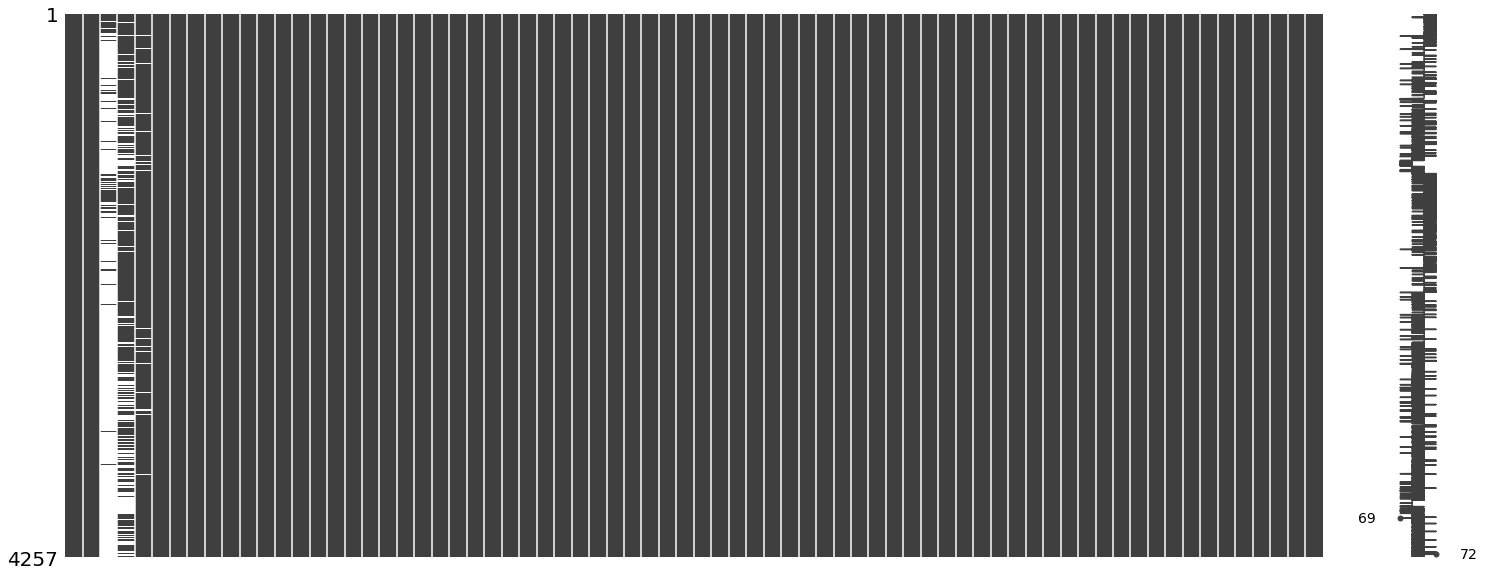

In [171]:
import missingno as msno
msno.matrix(players)
plt.show()

# Correlation


In [172]:
corr_matrix = players.corr()

corr_matrix.style.background_gradient(cmap='coolwarm')


,born_date,ht,rank,o_rank,w_clay,w_hard,w_carpet,w_grass,Clay,Hard,Carpet,Grass,tourney_win,tourney_count,match_lost,match_win,match_count,o_1stIn,o_1stWon,o_2ndWon,o_SvGms,o_ace,o_bpFaced,o_bpSaved,o_df,o_svpt,minutes,1stIn,1stWon,2ndWon,SvGms,ace,bpFaced,bpSaved,df,svpt,n_sets,sets_won,games_won,o_games_won,o_sets_won,tiebreaks_total,tb_won,o_tb_won,2ndIn,o_2ndIn,tourney_importance,mean_tourney_importance,%w_clay,%w_hard,%w_grass,%w_carpet,%wins,%fsw,%ssw,%ace,%df,gpm,%tb_won,%bp_saved,%succ1serve,1st_srp_won,%1st_srp_won,2nd_srp_won,%2nd_srp_won,bp_won,%bp_won,minutes_x_match
born_date,1.000000,-0.128055,0.219117,0.106872,-0.141573,-0.188428,-0.040408,-0.174755,-0.161047,-0.204757,-0.046963,-0.193936,-0.120605,-0.227689,-0.227311,-0.198423,-0.214409,-0.212806,-0.215027,-0.216593,-0.214442,-0.219455,-0.203039,-0.206462,-0.211994,-0.213455,-0.211583,-0.213030,-0.213365,-0.211834,-0.213819,-0.191640,-0.209478,-0.210651,-0.194963,-0.213568,-0.214422,-0.203023,-0.210808,-0.217460,-0.223663,-0.206825,-0.197726,-0.212430,-0.213332,-0.214239,-0.197180,0.007492,-0.174478,-0.199913,-0.185733,-0.033568,-0.202305,-0.200910,-0.111063,-0.193069,0.119113,-0.140047,-0.156234,-0.153472,-0.087875,-0.205333,-0.037944,-0.210490,-0.084641,-0.197103,-0.057763,-0.086790
ht,-0.128055,1.000000,0.071835,0.078783,0.089305,0.093147,0.044689,0.071821,0.101353,0.081206,0.049434,0.059968,0.142666,0.097601,0.089555,0.114506,0.107194,0.146634,0.206067,0.210663,0.174644,0.308308,-0.021879,0.039017,0.036533,0.148799,0.126519,0.134760,0.207641,0.198168,0.176373,0.454940,-0.050930,0.011575,0.102091,0.146774,0.139991,0.144844,0.169769,0.171211,0.127679,0.382961,0.379109,0.376010,0.168516,0.165254,0.053306,-0.200387,-0.015711,0.014301,-0.011688,0.040842,0.028382,0.590250,0.272707,0.628405,-0.076548,0.339787,0.034675,0.370024,-0.095988,0.014913,-0.567484,0.109694,-0.392945,-0.100981,-0.313946,0.043509
rank,0.219117,0.071835,1.000000,0.658139,-0.425364,-0.508303,-0.027671,-0.376289,-0.453222,-0.537760,-0.023816,-0.432840,-0.334685,-0.584944,-0.586367,-0.551075,-0.575475,-0.568117,-0.560540,-0.559366,-0.564472,-0.503300,-0.574944,-0.573166,-0.584536,-0.567473,-0.566208,-0.568065,-0.557490,-0.554680,-0.564087,-0.470723,-0.586446,-0.580663,-0.556875,-0.568803,-0.569535,-0.551307,-0.560022,-0.569483,-0.579287,-0.507192,-0.496498,-0.507936,-0.561219,-0.562604,-0.555725,-0.386012,-0.553696,-0.557756,-0.485413,-0.022223,-0.580132,-0.290760,-0.256639,-0.164028,0.237232,-0.310585,-0.399998,-0.269114,-0.179325,-0.575983,-0.445448,-0.563773,-0.441553,-0.573075,-0.232042,-0.375251
o_rank,0.106872,0.078783,0.658139,1.000000,-0.299164,-0.350641,-0.016962,-0.253023,-0.323808,-0.377606,-0.015812,-0.294216,-0.221301,-0.415165,-0.417358,-0.378313,-0.401491,-0.394537,-0.390700,-0.390606,-0.393088,-0.355670,-0.395964,-0.395675,-0.405544,-0.394249,-0.392847,-0.394890,-0.387474,-0.386602,-0.392744,-0.331072,-0.409534,-0.404926,-0.390428,-0.395819,-0.396505,-0.378891,-0.387675,-0.398433,-0.409514,-0.354388,-0.345653,-0.356681,-0.391503,-0.391302,-0.381877,-0.314025,-0.412111,-0.388671,-0.345286,-0.015946,-0.420735,-0.242053,-0.173638,-0.173436,0.210789,-0.227370,-0.364153,-0.240042,-0.129533,-0.397442,-0.271814,-0.390407,-0.278297,-0.393664,-0.156838,-0.256692
w_clay,-0.141573,0.089305,-0.425364,-0.299164,1.000000,0.491348,0.003359,0.333033,0.987353,0.520246,0.012262,0.388258,0.602014,0.770912,0.765082,0.788943,0.789121,0.786904,0.779498,0.782165,0.786663,0.687930,0.790113,0.792459,0.755950,0.786740,0.797744,0.789104,0.781365,0.777553,0.786420,0.634901,0.782533,0.789283,0.721142,0.786358,0.788558,0.787437,0.786675,0.781623,0.774900,0.723116,0.711472,0.721326,0.776634,0.788227,0.741510,0.237052,0.559323,0.361691,0.413958,0.002610,0.422292,0.248876,0.202076,0.166177,-0.183109,0.237288,0.297617,0.222598,0.116875,0.792267,0.176224,0.792020,0.215218,0.781666,0.092793,0.259229
w_hard,-0.188428,0.093147,-0.508303,-0.350641,0.491348,1.000000,0.056857,0.770981,0.513020,0.986857,0.064682,0.824859

# Save pickle

In [173]:
players.columns.values

array(['id', 'born_date', 'ht', 'rank', 'o_rank', 'hand', 'gender', 'ioc',
       'w_clay', 'w_hard', 'w_carpet', 'w_grass', 'Clay', 'Hard',
       'Carpet', 'Grass', 'tourney_win', 'tourney_count', 'match_lost',
       'match_win', 'match_count', 'o_1stIn', 'o_1stWon', 'o_2ndWon',
       'o_SvGms', 'o_ace', 'o_bpFaced', 'o_bpSaved', 'o_df', 'o_svpt',
       'minutes', '1stIn', '1stWon', '2ndWon', 'SvGms', 'ace', 'bpFaced',
       'bpSaved', 'df', 'svpt', 'n_sets', 'sets_won', 'games_won',
       'o_games_won', 'o_sets_won', 'tiebreaks_total', 'tb_won',
       'o_tb_won', '2ndIn', 'o_2ndIn', 'tourney_importance',
       'mean_tourney_importance', '%w_clay', '%w_hard', '%w_grass',
       '%w_carpet', '%wins', '%fsw', '%ssw', '%ace', '%df', 'gpm',
       '%tb_won', '%bp_saved', '%succ1serve', '1st_srp_won',
       '%1st_srp_won', '2nd_srp_won', '%2nd_srp_won', 'bp_won', '%bp_won',
       'minutes_x_match'], dtype=object)

In [174]:
players.drop(['w_clay', 'w_hard', 'w_carpet', 'w_grass', 'Clay', 'Hard',
       'Carpet', 'Grass', 'tourney_win', 'tourney_count', 'match_lost',
       'match_win', 'match_count', 'o_1stIn', 'o_1stWon', 'o_2ndIn',
       'o_2ndWon', 'o_SvGms', 'o_ace', 'o_bpFaced', 'o_bpSaved', 'o_df',
       'o_games_won', 'o_sets_won', 'o_svpt', 'o_tb_won', 'minutes',
       'n_sets', 'tiebreaks_total', '1stIn', '1stWon', '2ndIn', '2ndWon',
       'SvGms', 'ace', 'bpFaced', 'bpSaved', 'df', 'games_won',
       'sets_won', 'svpt', 'tb_won','1st_srp_won', '2nd_srp_won','bp_won'], inplace=True, axis=1)
players.columns.values

array(['id', 'born_date', 'ht', 'rank', 'o_rank', 'hand', 'gender', 'ioc',
       'tourney_importance', 'mean_tourney_importance', '%w_clay',
       '%w_hard', '%w_grass', '%w_carpet', '%wins', '%fsw', '%ssw',
       '%ace', '%df', 'gpm', '%tb_won', '%bp_saved', '%succ1serve',
       '%1st_srp_won', '%2nd_srp_won', '%bp_won', 'minutes_x_match'],
      dtype=object)

In [175]:
players.to_pickle('drive/MyDrive/dm_dataset/players_tourney_importance.pkl')